##### IMPORTS

In [149]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [150]:
from tensorflow import keras as tfk
from tensorflow.keras import layers

print(tf.__version__)
print(tfk.models.load_model)

2.13.0
<function load_model at 0x0000028996FBA3B0>


##### DEFINITIONS

In [151]:
def get_img_array(img_path, size):
    img = tfk.preprocessing.image.load_img(img_path, target_size=size)
    array = tfk.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 180, 180, 3)
    array = np.expand_dims(array, axis=0)
    return array

##### ROOT

In [152]:
root = Path.cwd()

##### EXAMPLE IMAGE

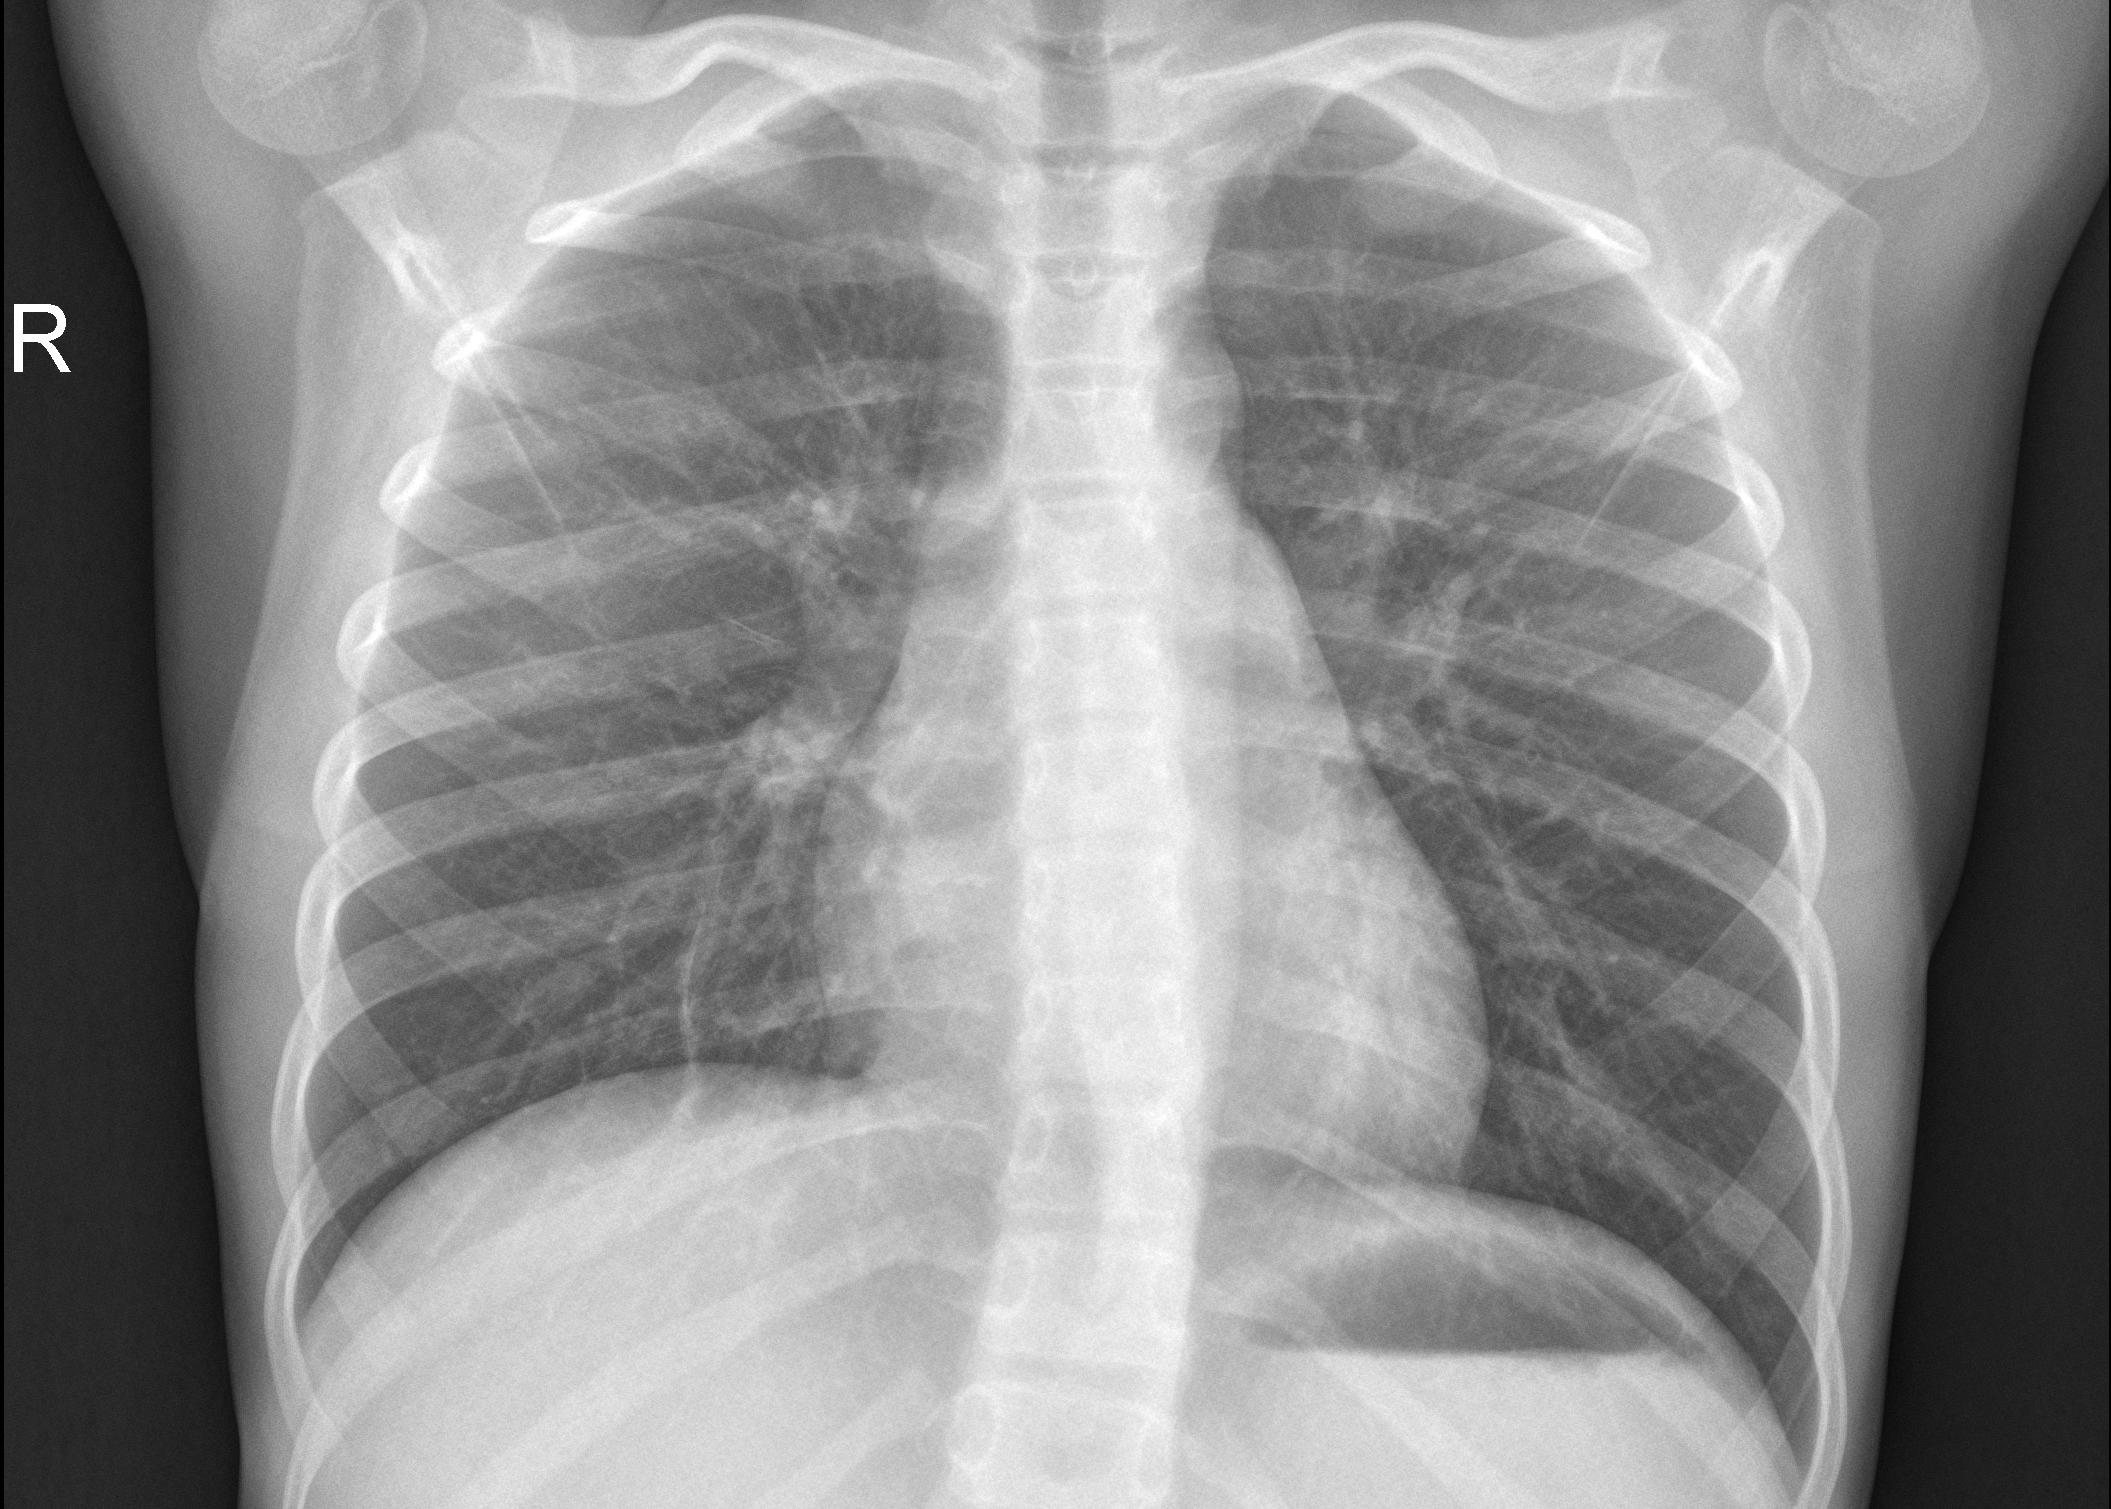

In [153]:
# The local path to our target image
img_size = (180,180)

img_path = root / "../data/data_sample/chest_xray/NORMAL/IM-0003-0001.jpeg"
display(Image(img_path))

##### PREPARE IMAGE

In [154]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array(img_path, size=img_size)

##### LOAD PRETRAINED MODEL

In [155]:
model_path = root / "../data_preparation/model_output/xray_model.h5"
print(model_path)
print()
print("Loaded with keras")
print()

model = tfk.models.load_model(model_path, compile=False)
model.summary()

C:\Users\Giacomo Da Re\git\HC4AI\notebook\..\data_preparation\model_output\xray_model.h5

Loaded with keras

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 separable_conv2d 

In [156]:
last_conv_layer_name = "dropout_1"

In [157]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [158]:
# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

1/1 [==============================] - 1s 516ms/step
[[2.6625528]]


##### GRADCAM

In [159]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tfk.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

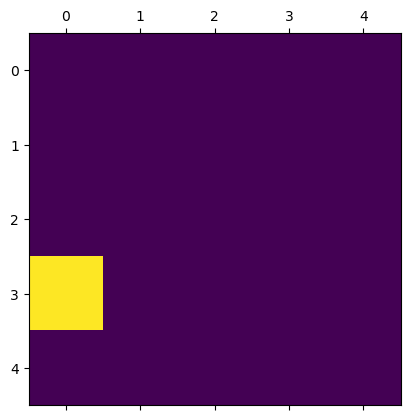

In [160]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [161]:
def save_and_display_gradcam(img_path, heatmap, ax, out_path, alpha=0.4):
    # Load the original image
    img = tfk.preprocessing.image.load_img(img_path)
    img = tfk.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(out_path)

    # Display Grad CAM
    display(Image(out_path))

    plt.imshow(superimposed_img)

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_38216\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


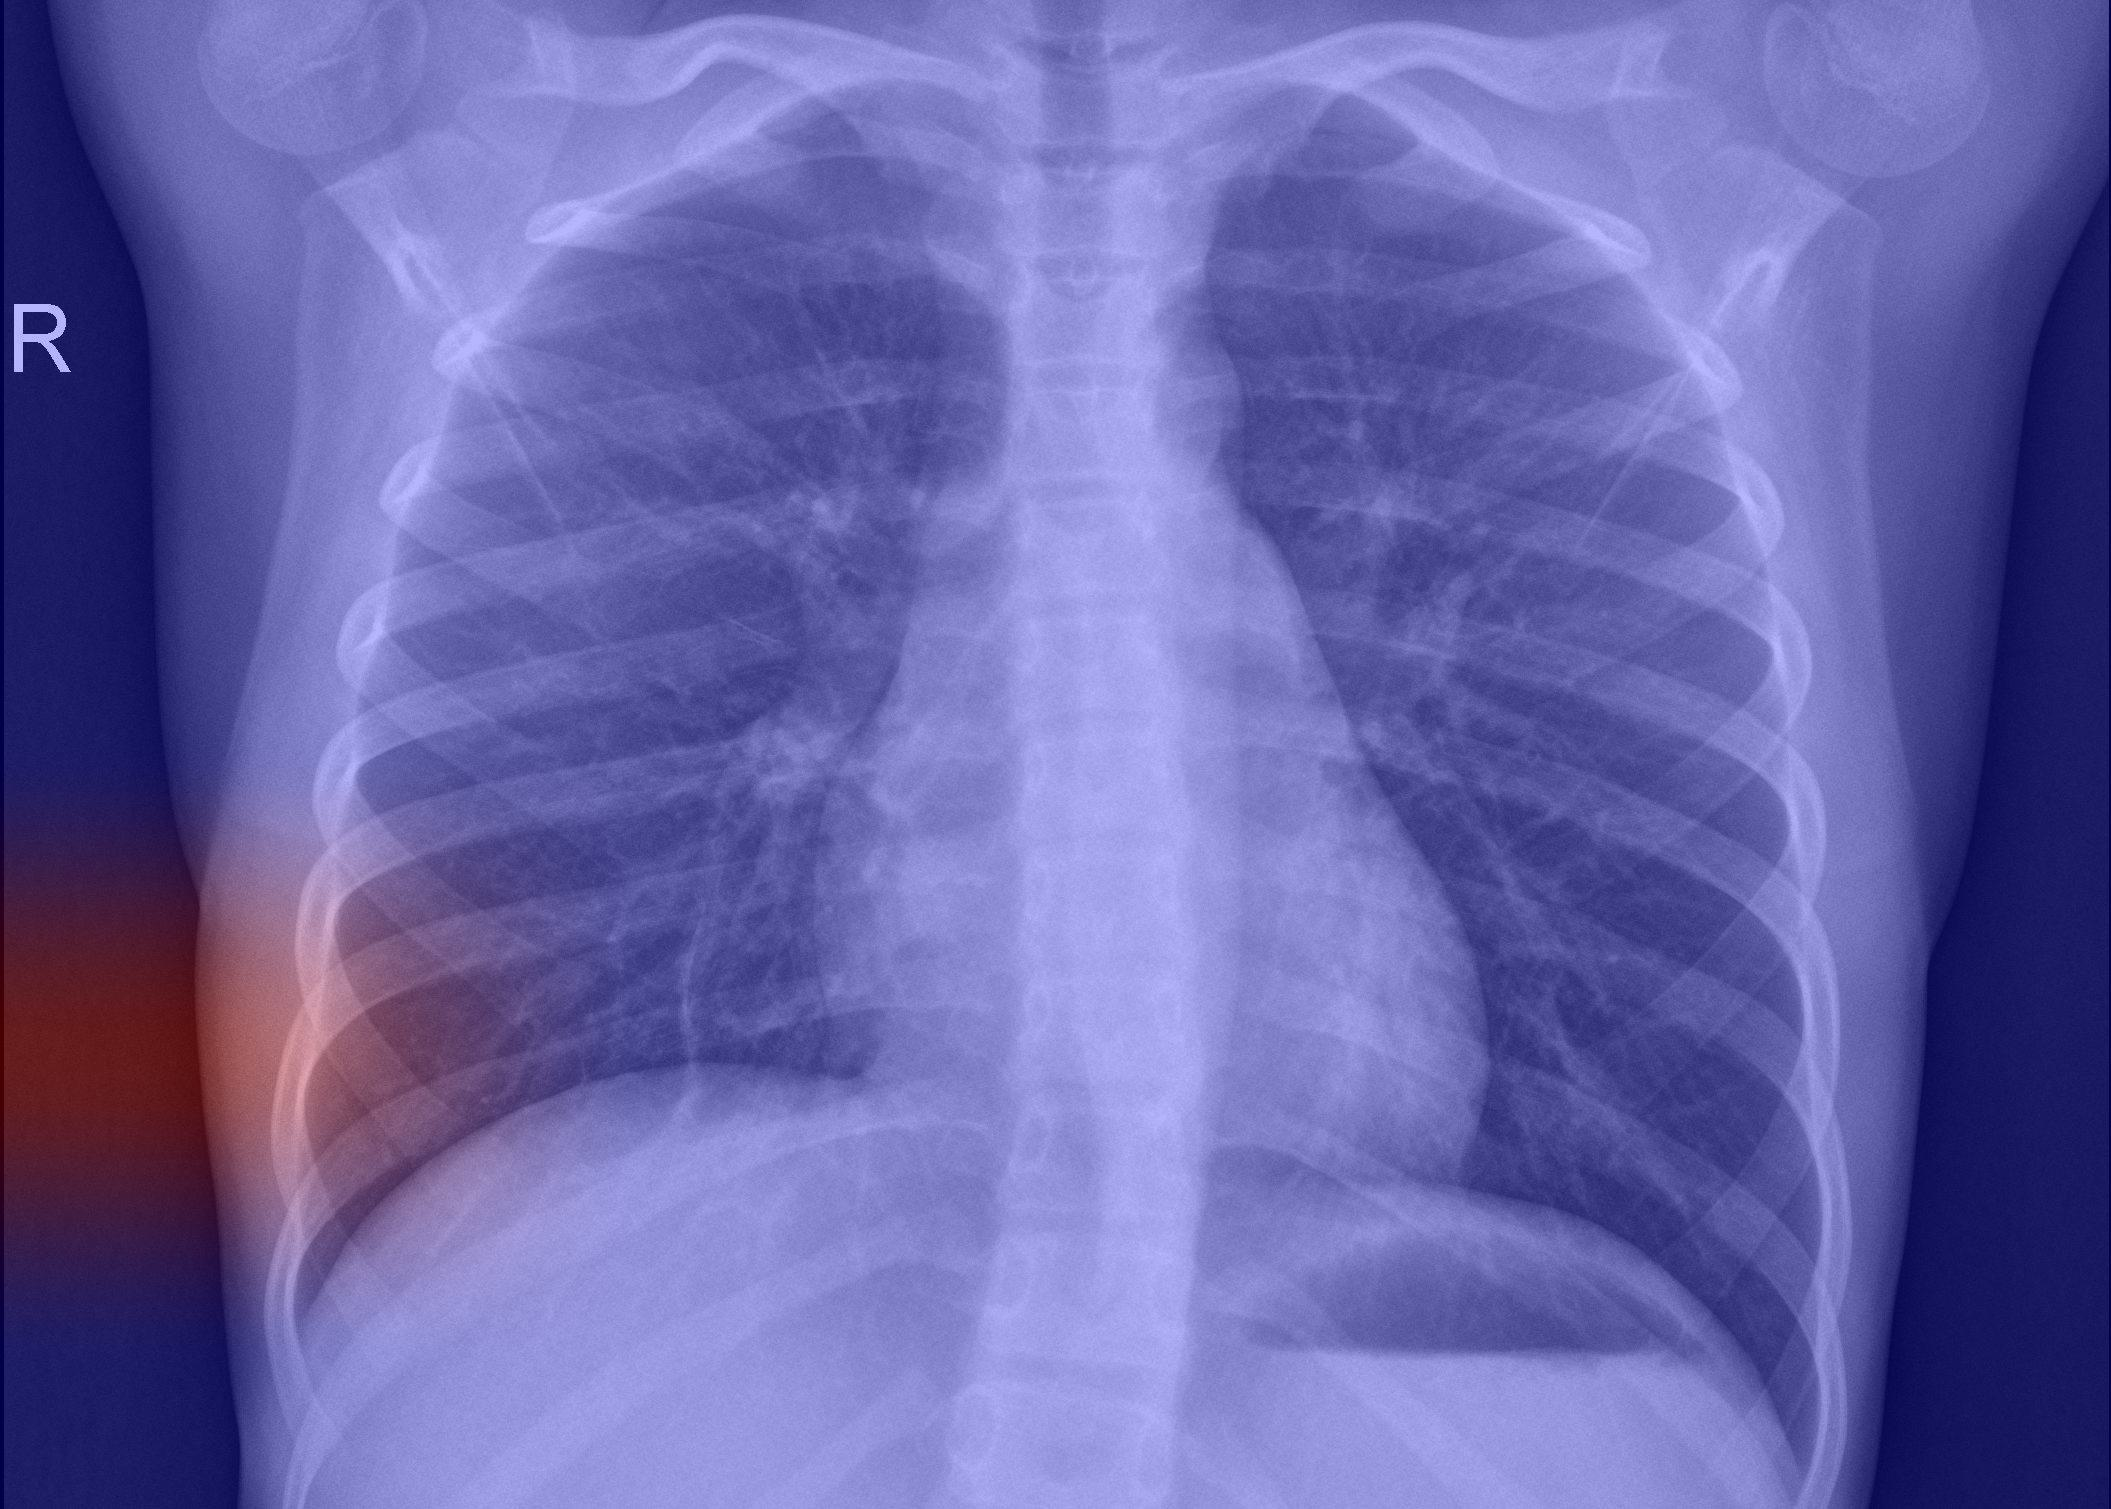

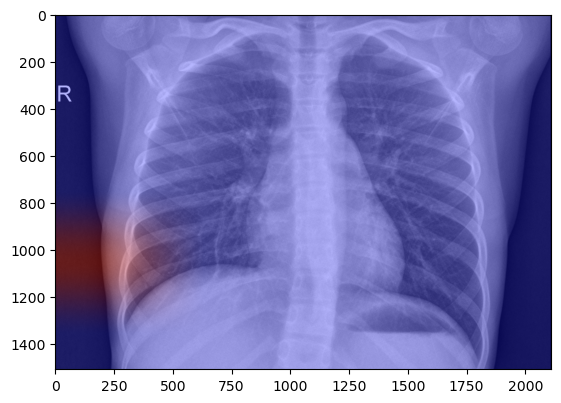

In [162]:
save_and_display_gradcam(img_path, heatmap, None, "../output/gradcam/xray_model/cam_ex.jpeg")

##### GENERATE AND SAVE PRINTS

In [163]:
N_images_paths = os.listdir('../data/data_sample/chest_xray/NORMAL')
P_images_paths = os.listdir('../data/data_sample/chest_xray/PNEUMONIA')

In [164]:
print(np.random.choice(N_images_paths, 3))

['IM-0037-0001.jpeg' 'IM-0023-0001.jpeg' 'IM-0036-0001.jpeg']


In [165]:
len(N_images_paths), len(P_images_paths)

(44, 44)

In [166]:
# Choose a number of images to show for each group
num_of_images_per_group = 3

In [167]:
# Get random images
random_N_images = np.random.choice(N_images_paths, num_of_images_per_group)
random_N_images = [path for path in random_N_images]
random_P_images = np.random.choice(P_images_paths, num_of_images_per_group)
random_P_images = [path for path in random_P_images]

In [168]:
# Concatenate them to get a unique list
images_path = np.concatenate((random_N_images, random_P_images))

In [169]:
def scan_label(label):

    if label == 'N':
        random_images = random_N_images
        data_folder_dir = '../data/data_sample/chest_xray/NORMAL/'
        dest_dir = "../output/gradcam/xray_model/NORMAL/"
    else:
        random_images = random_P_images
        data_folder_dir = '../data/data_sample/chest_xray/PNEUMONIA/'
        dest_dir = "../output/gradcam/xray_model/PNEUMONIA/"
        
    for i in range(0, num_of_images_per_group):
        img_path = data_folder_dir + random_images[i]
        img_dest_path = dest_dir + random_images[i]
        
        img = Image(img_path)
        display(img)
        img_array = get_img_array(img_path, size=img_size)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        save_and_display_gradcam(img_path, heatmap, None, img_dest_path)
        print()
        result = model.predict(img_array)
        print(img_path)
        print(img_dest_path)
        print(result)
        print('\n\n\n')

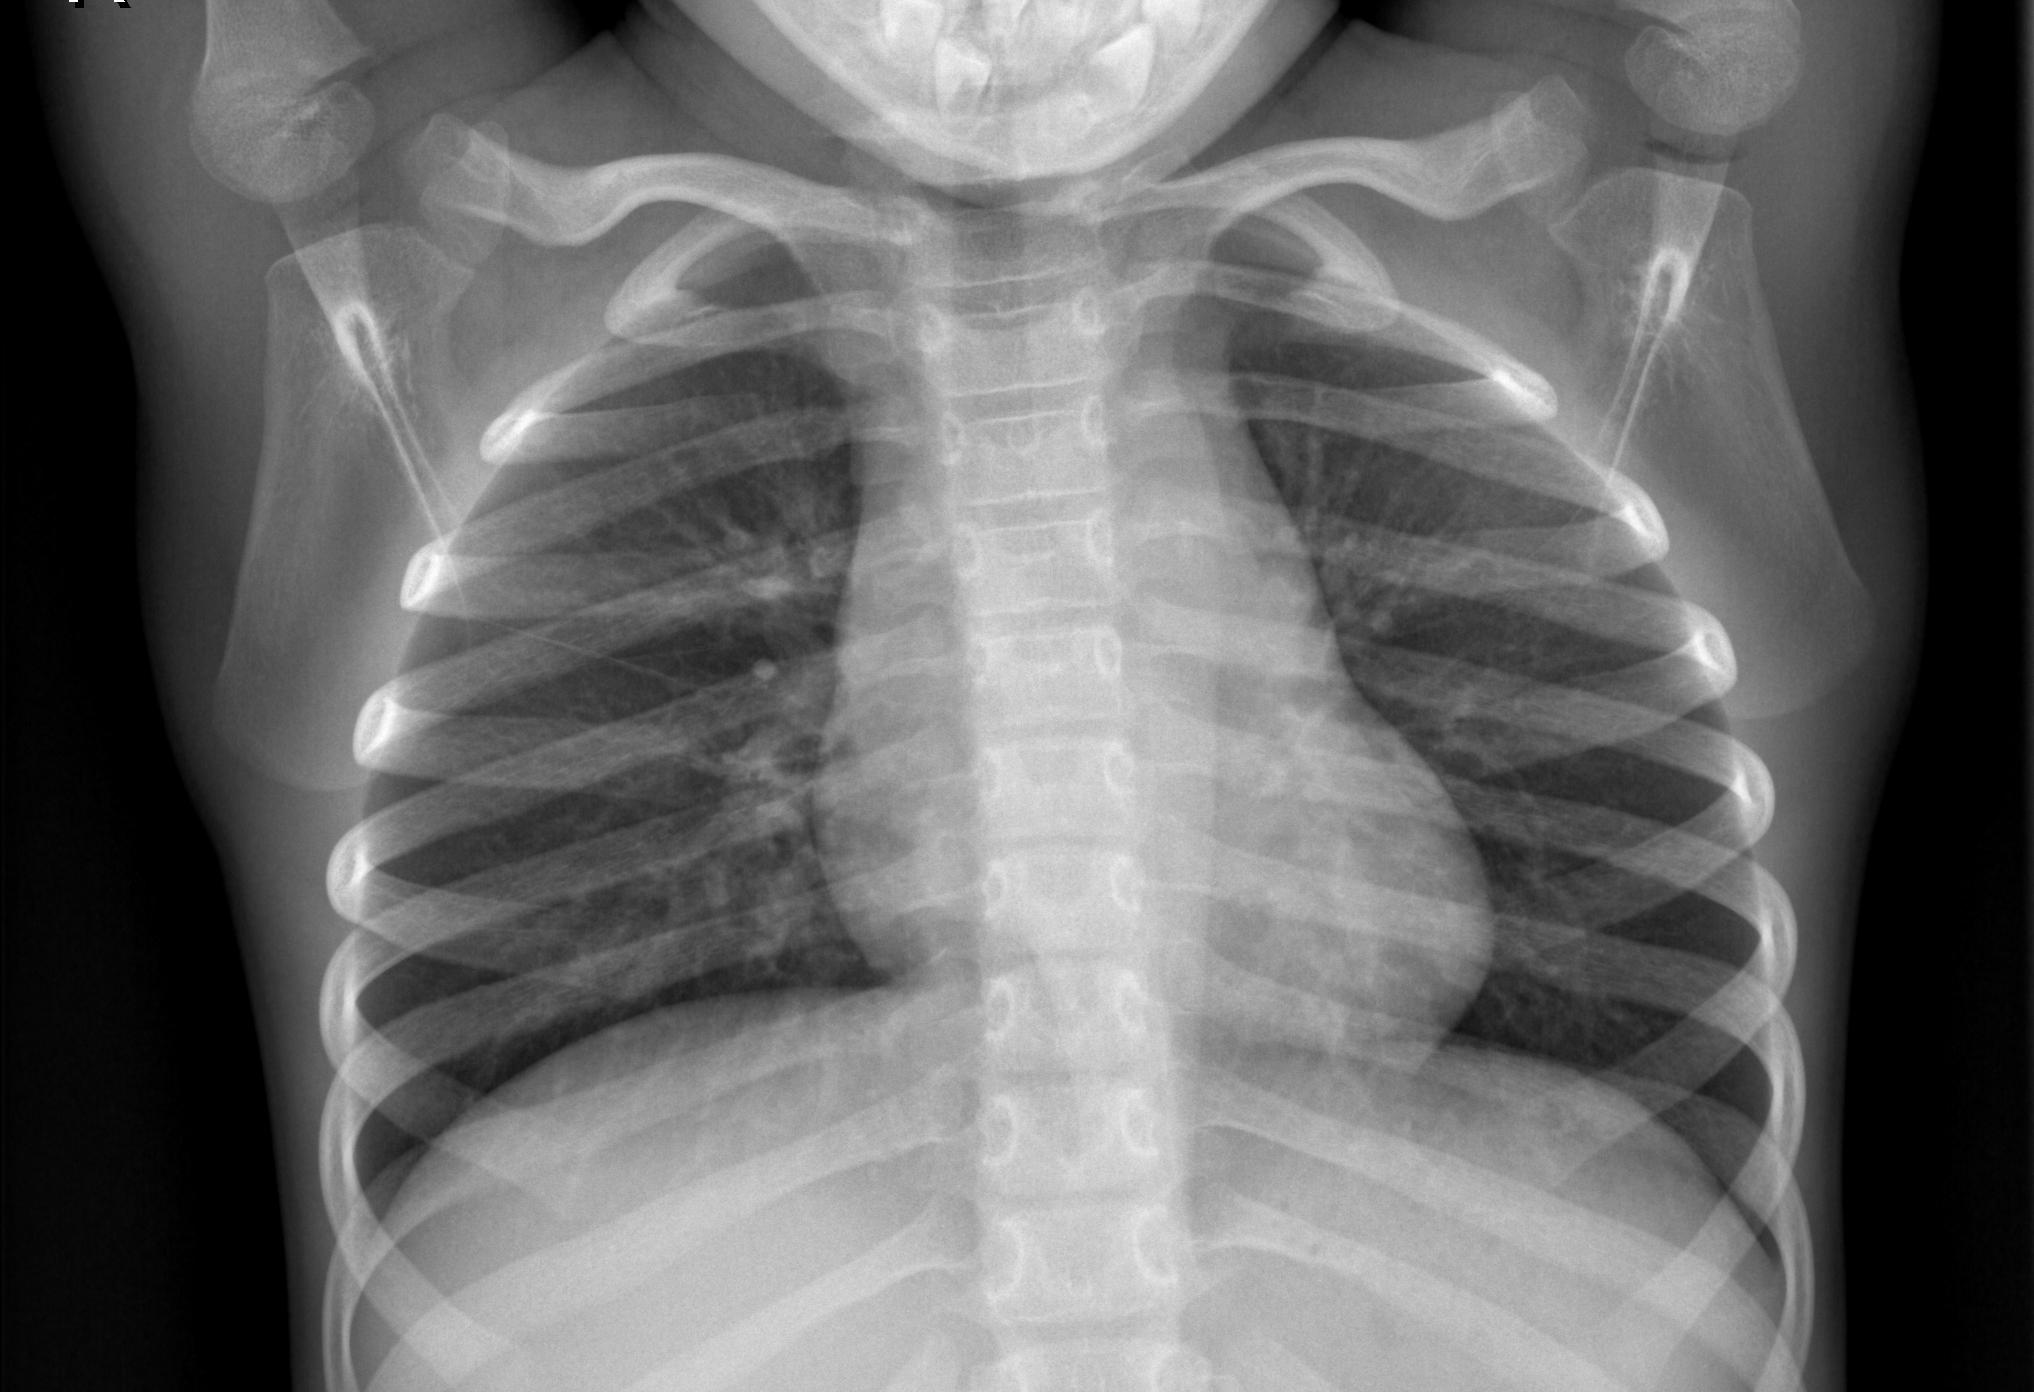

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_38216\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


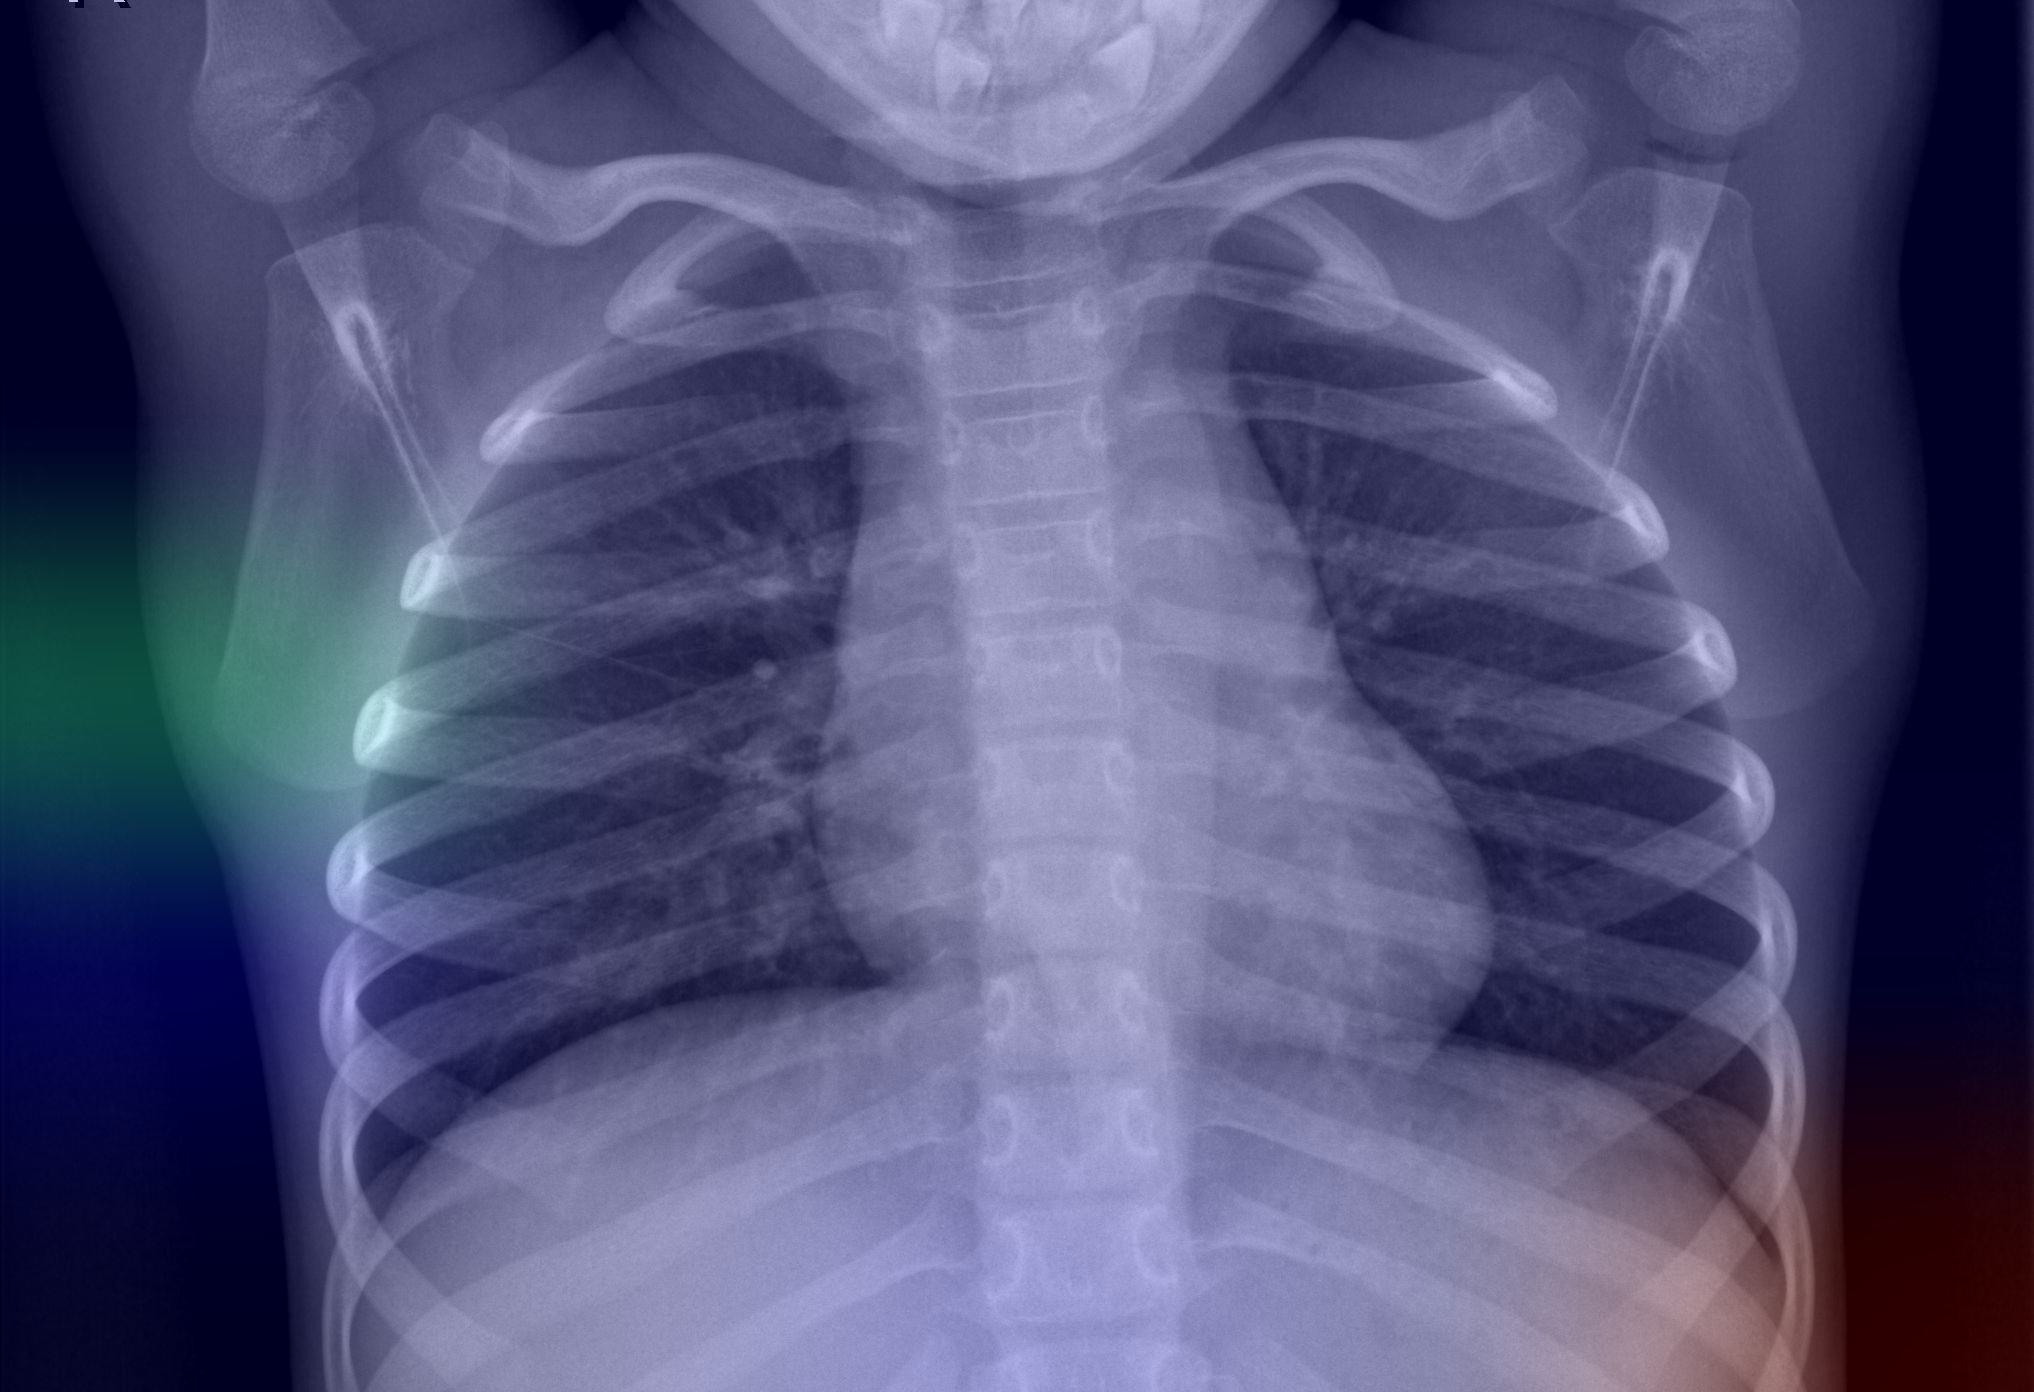


1/1 [==============================] - 0s 59ms/step
../data/data_sample/chest_xray/NORMAL/IM-0070-0001.jpeg
../output/gradcam/xray_model/NORMAL/IM-0070-0001.jpeg
[[-9.19572]]






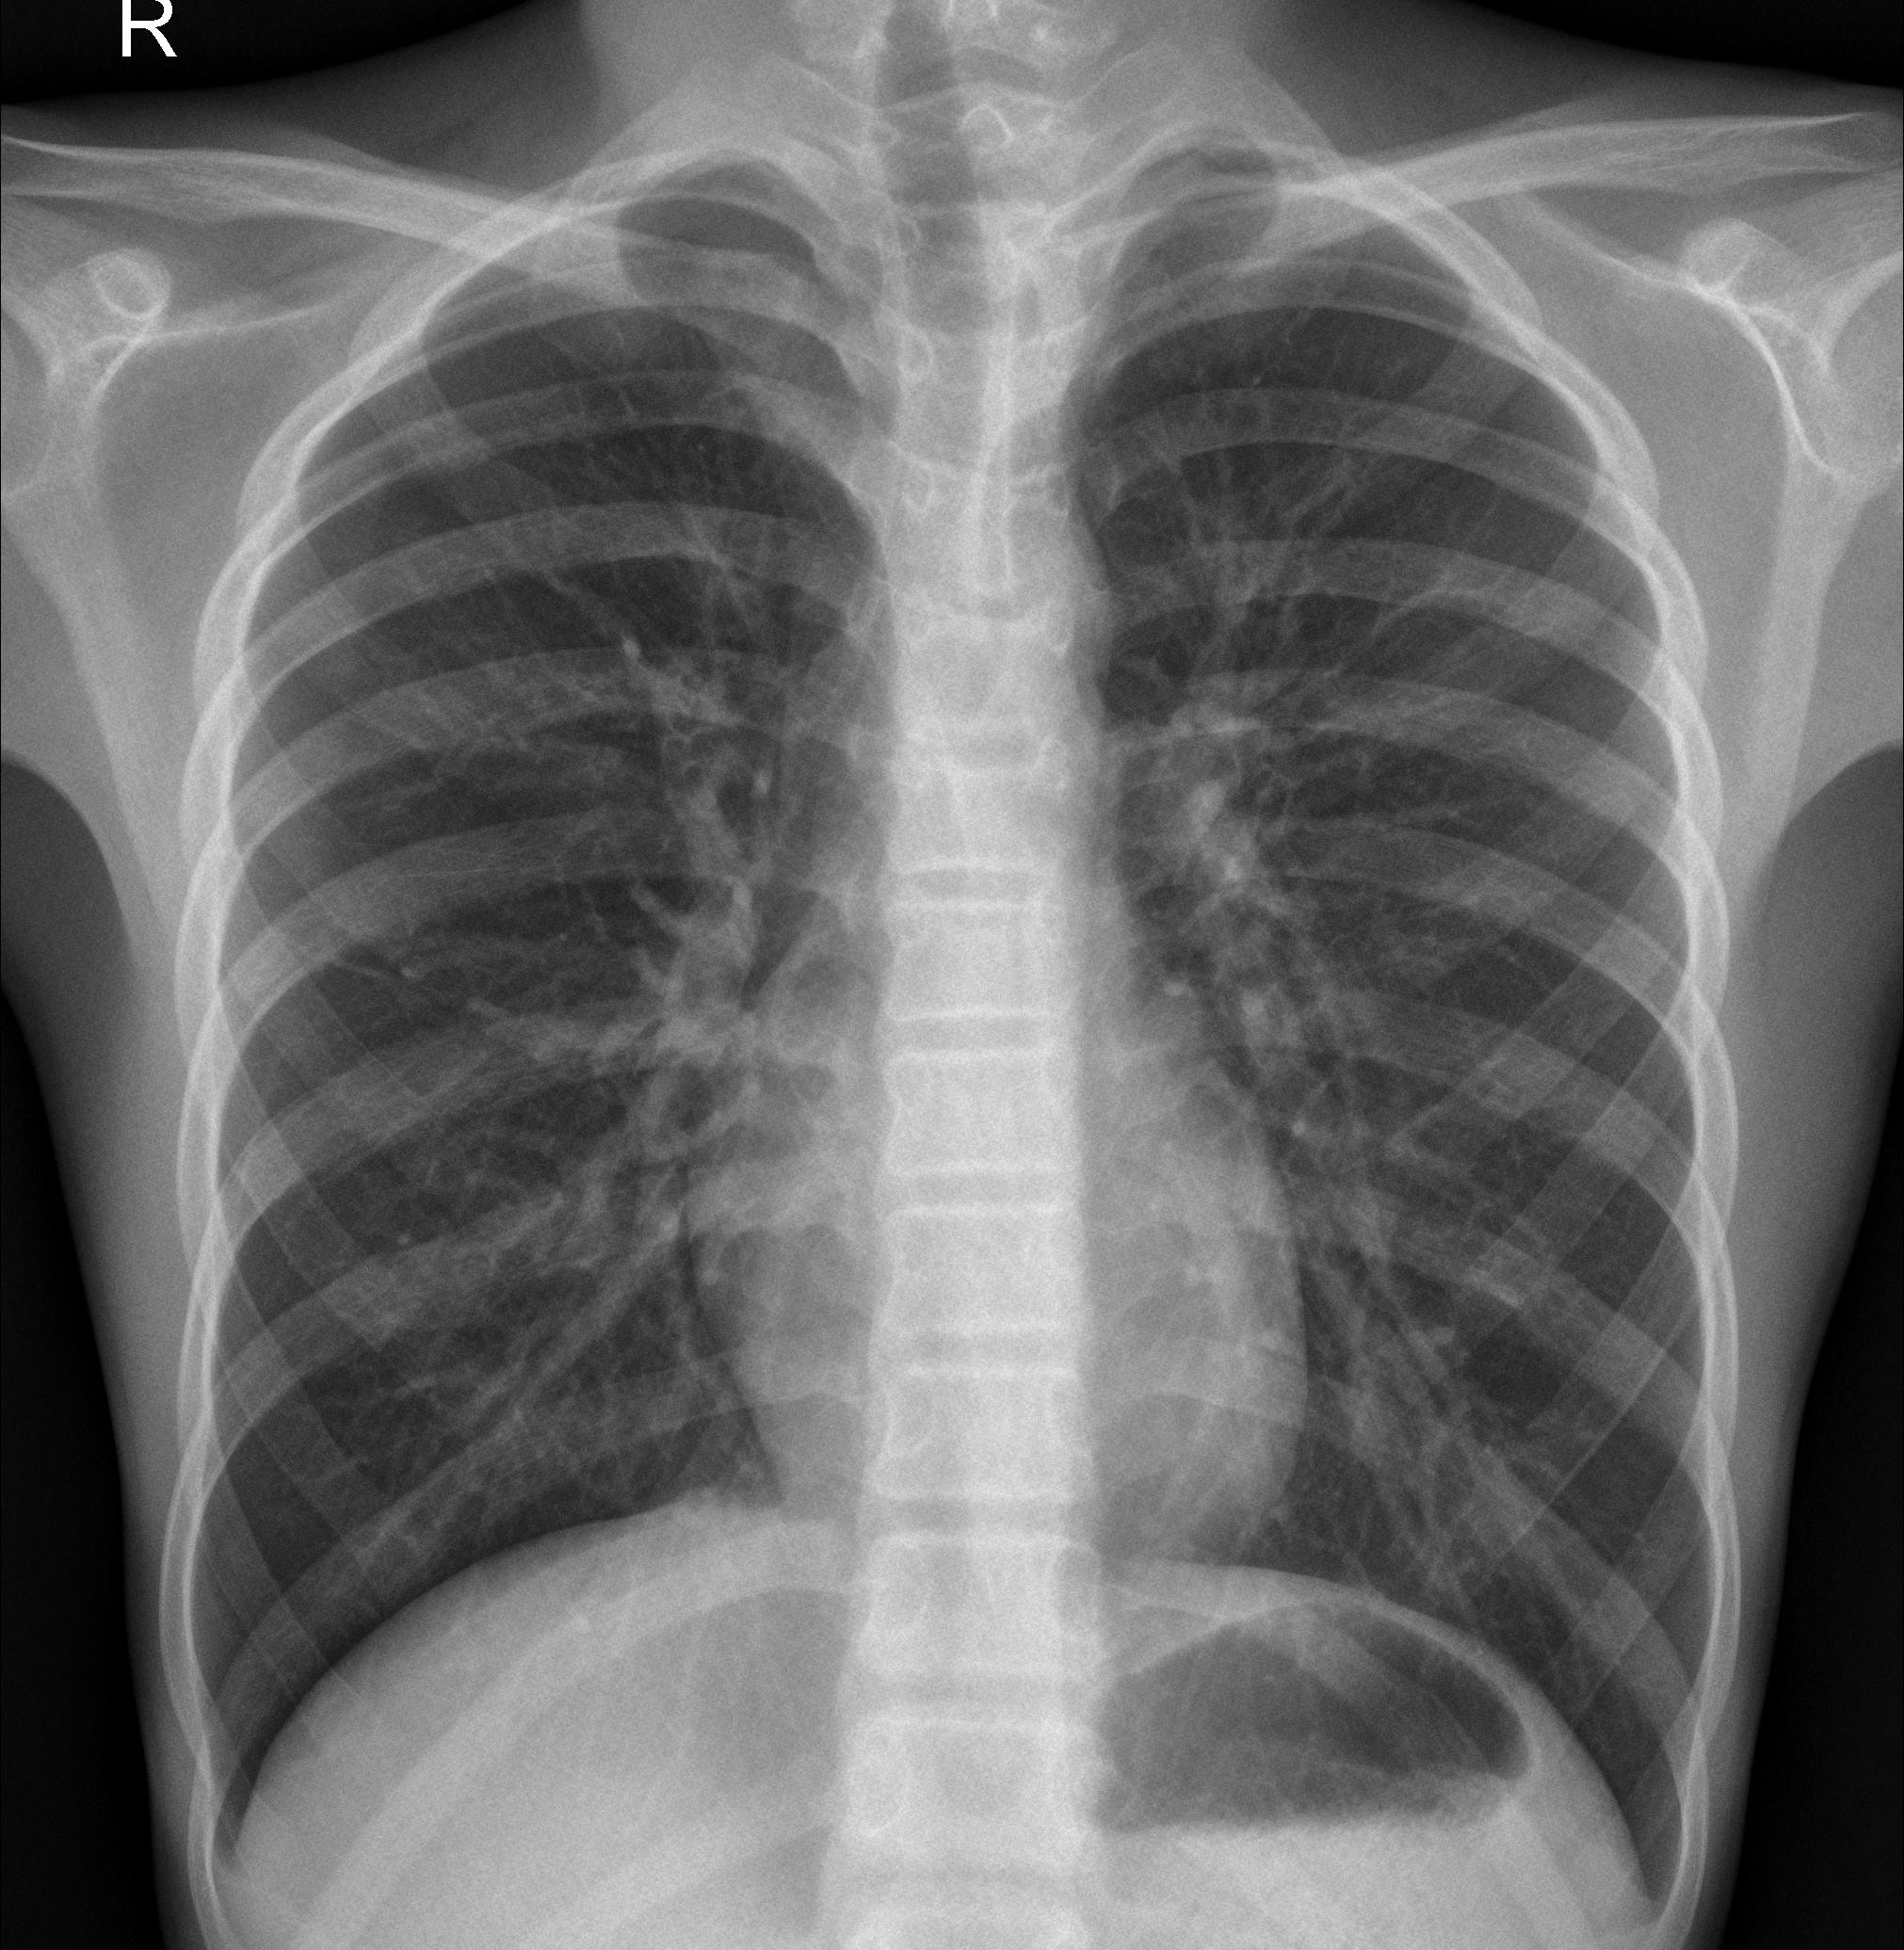

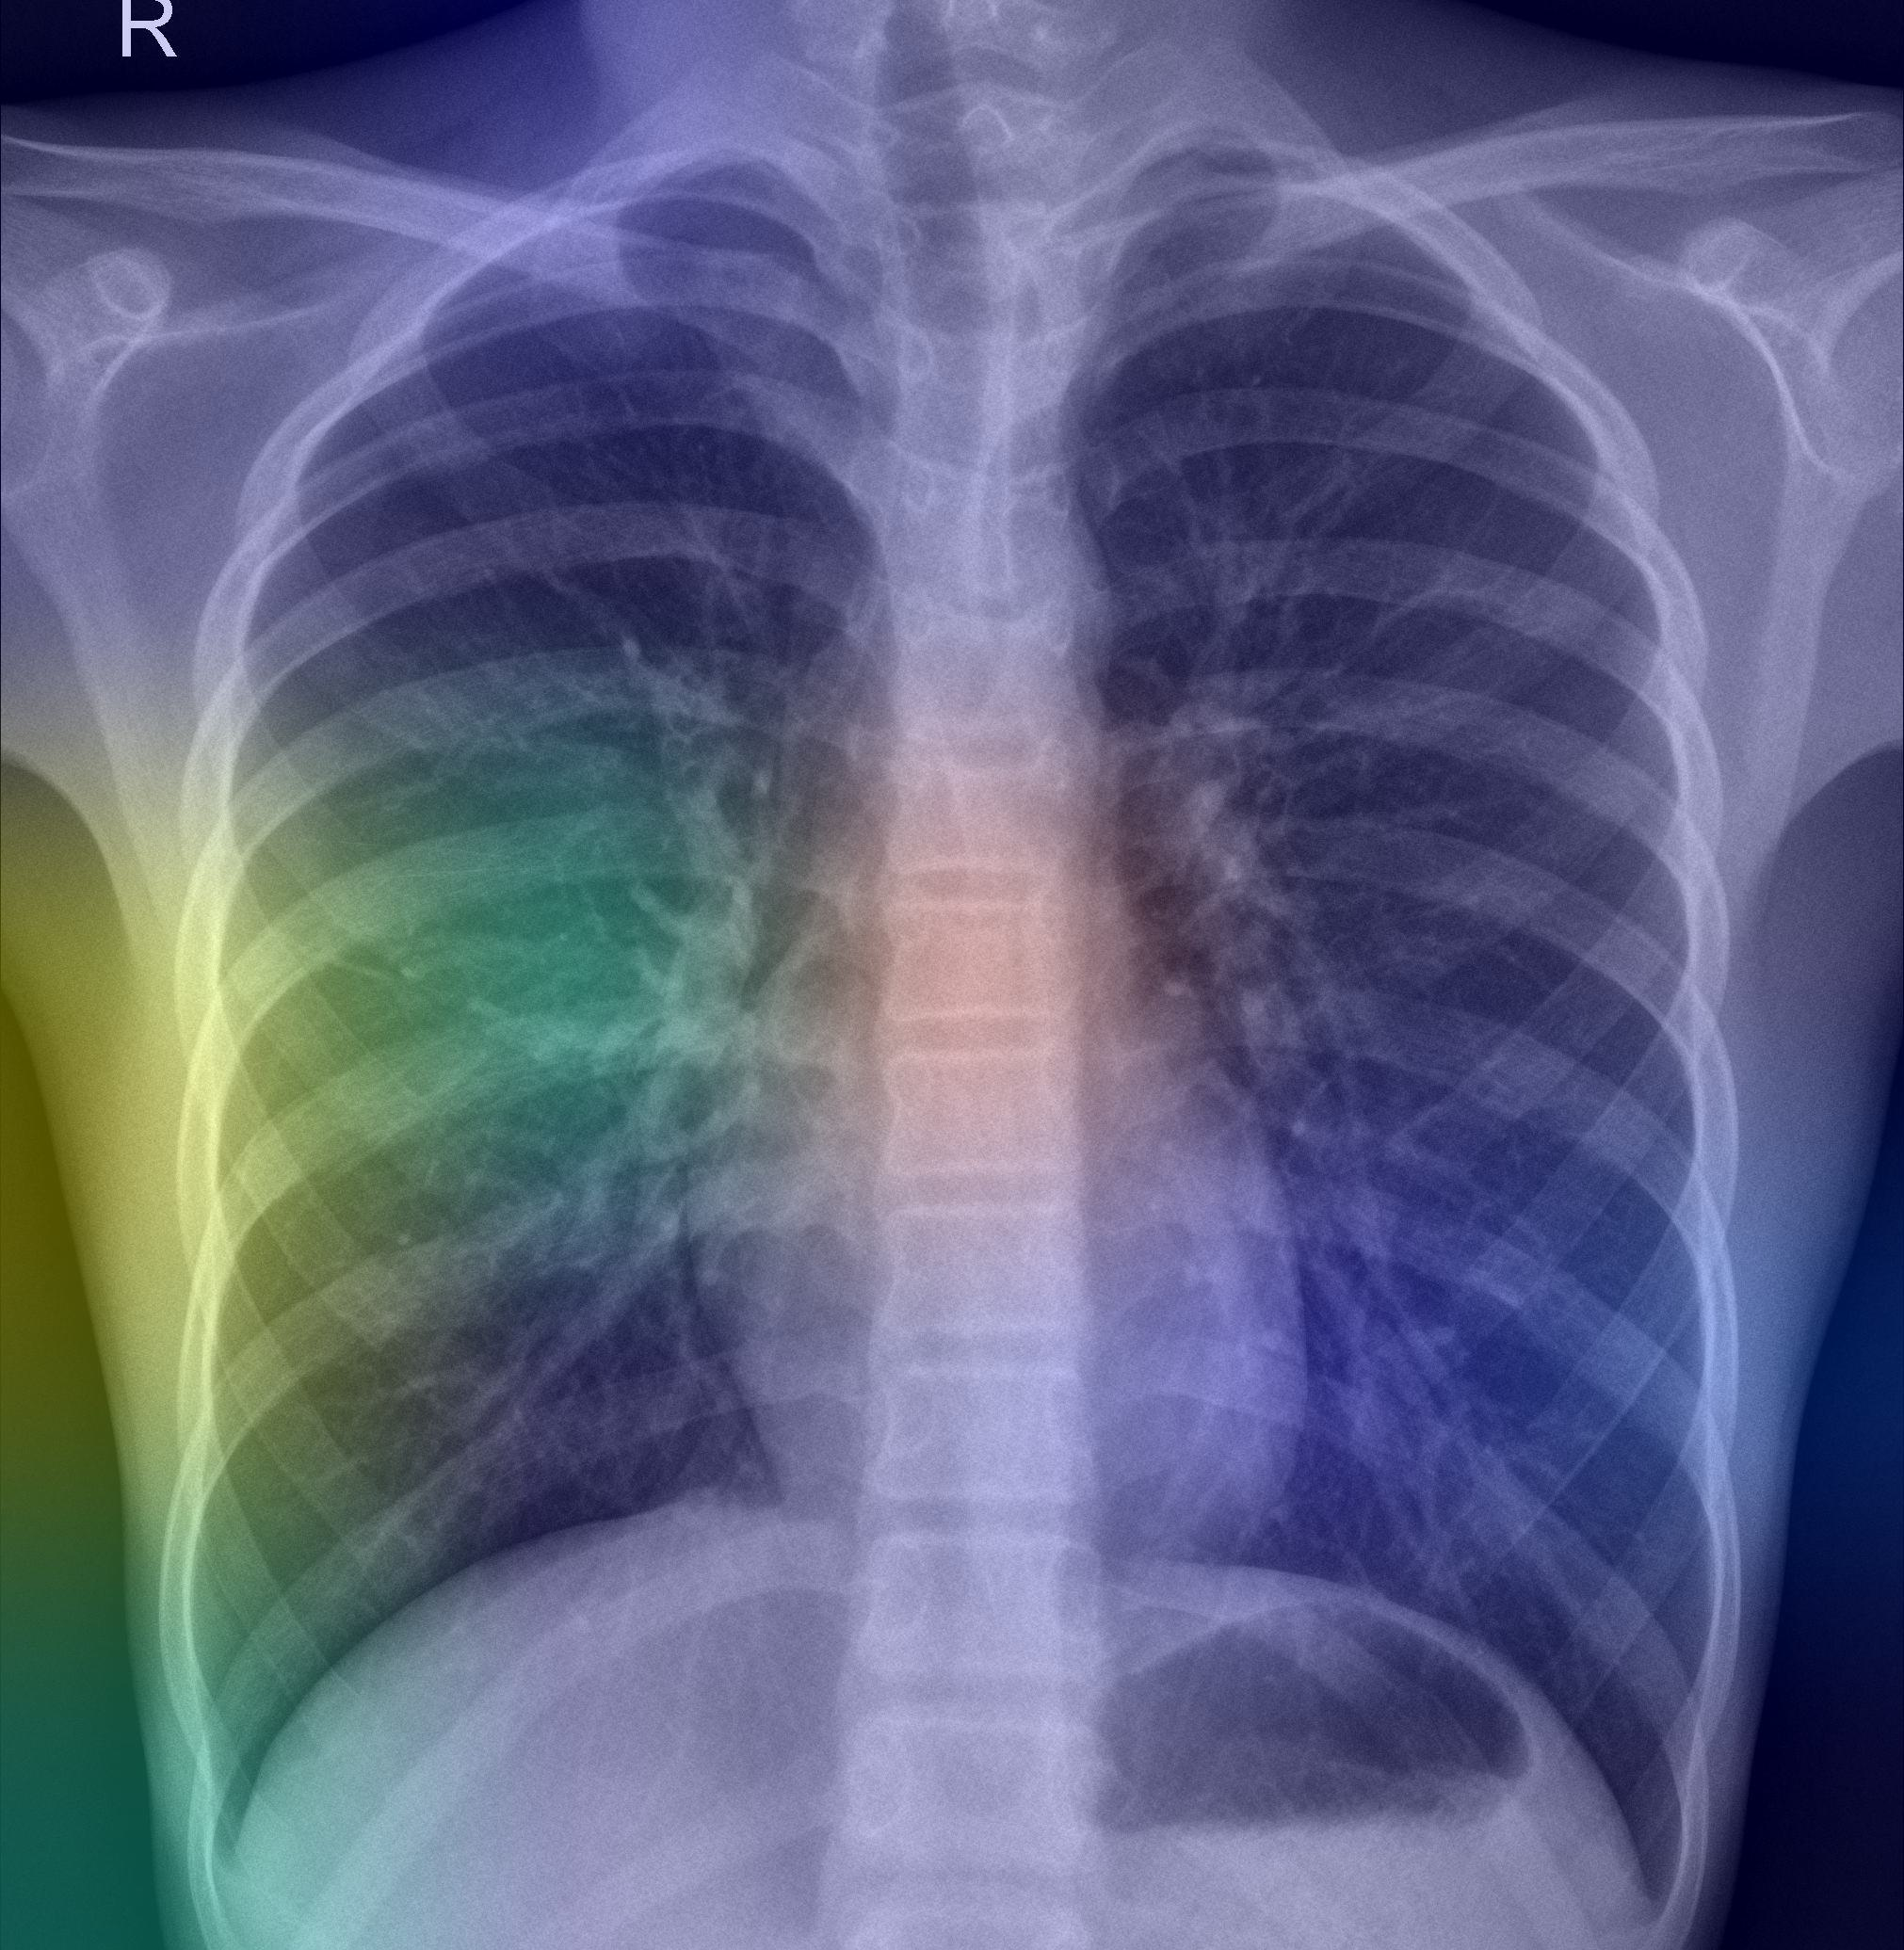


1/1 [==============================] - 0s 56ms/step
../data/data_sample/chest_xray/NORMAL/IM-0041-0001.jpeg
../output/gradcam/xray_model/NORMAL/IM-0041-0001.jpeg
[[5.4888005]]






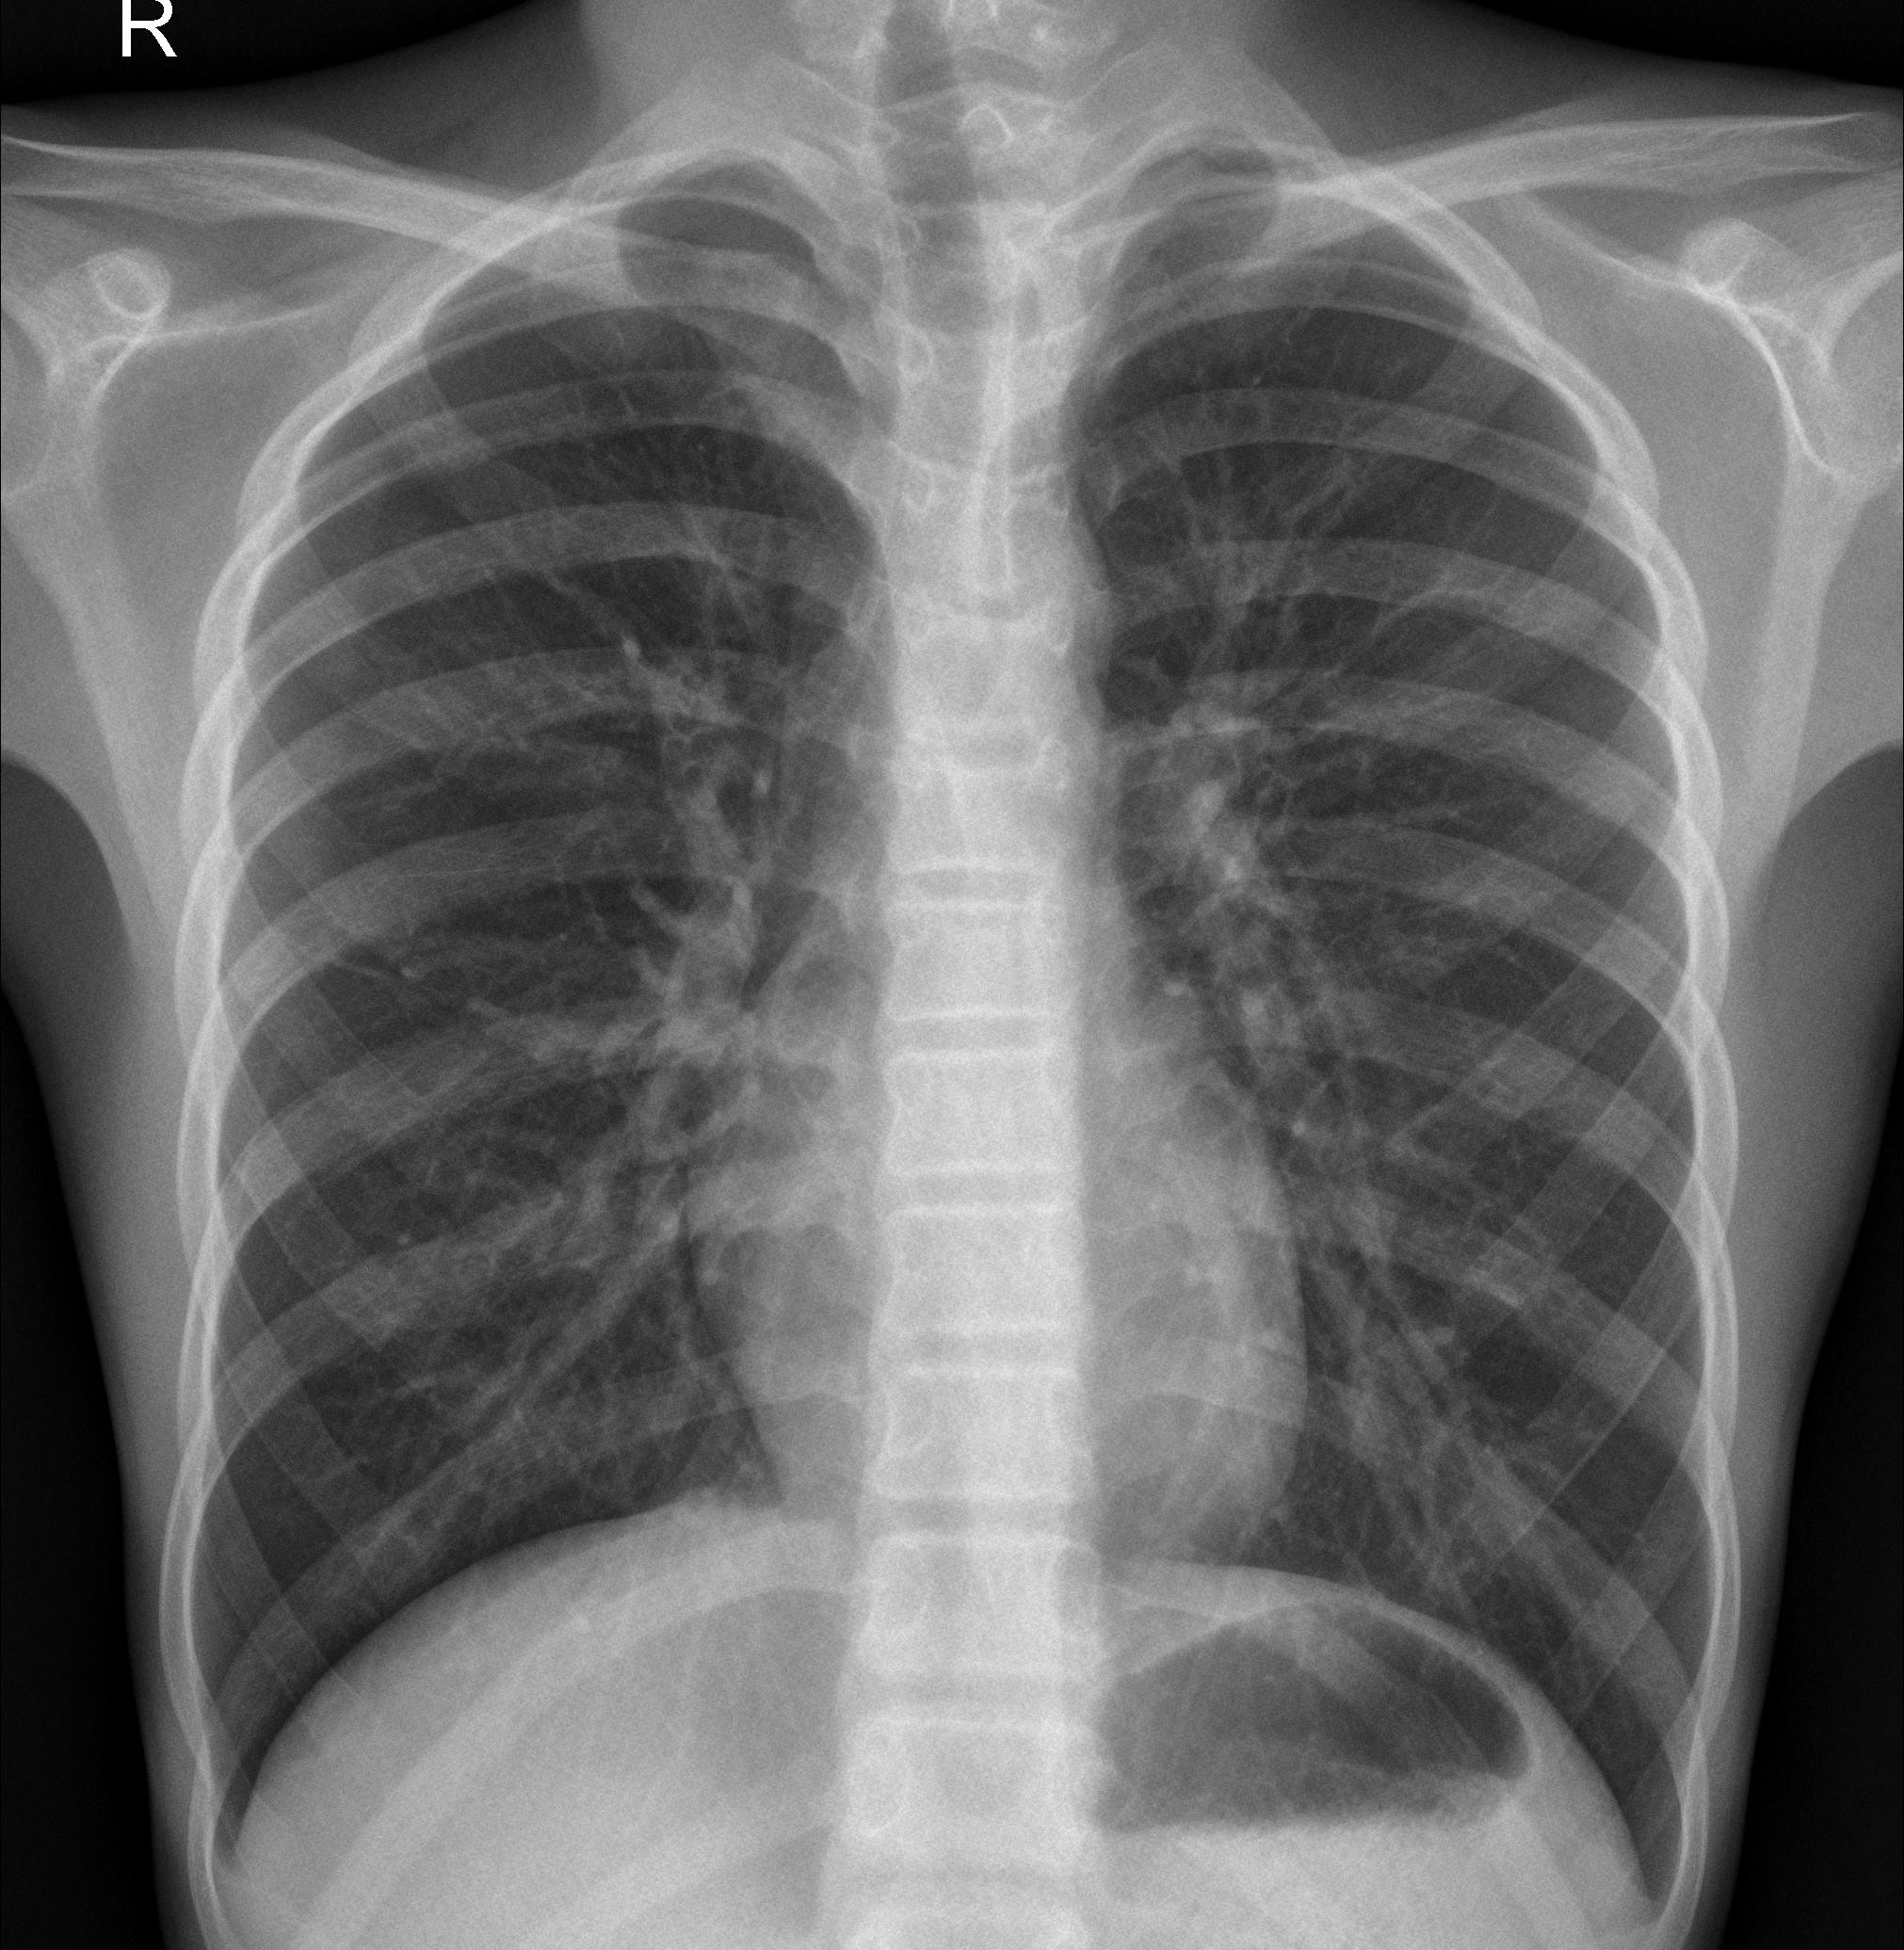

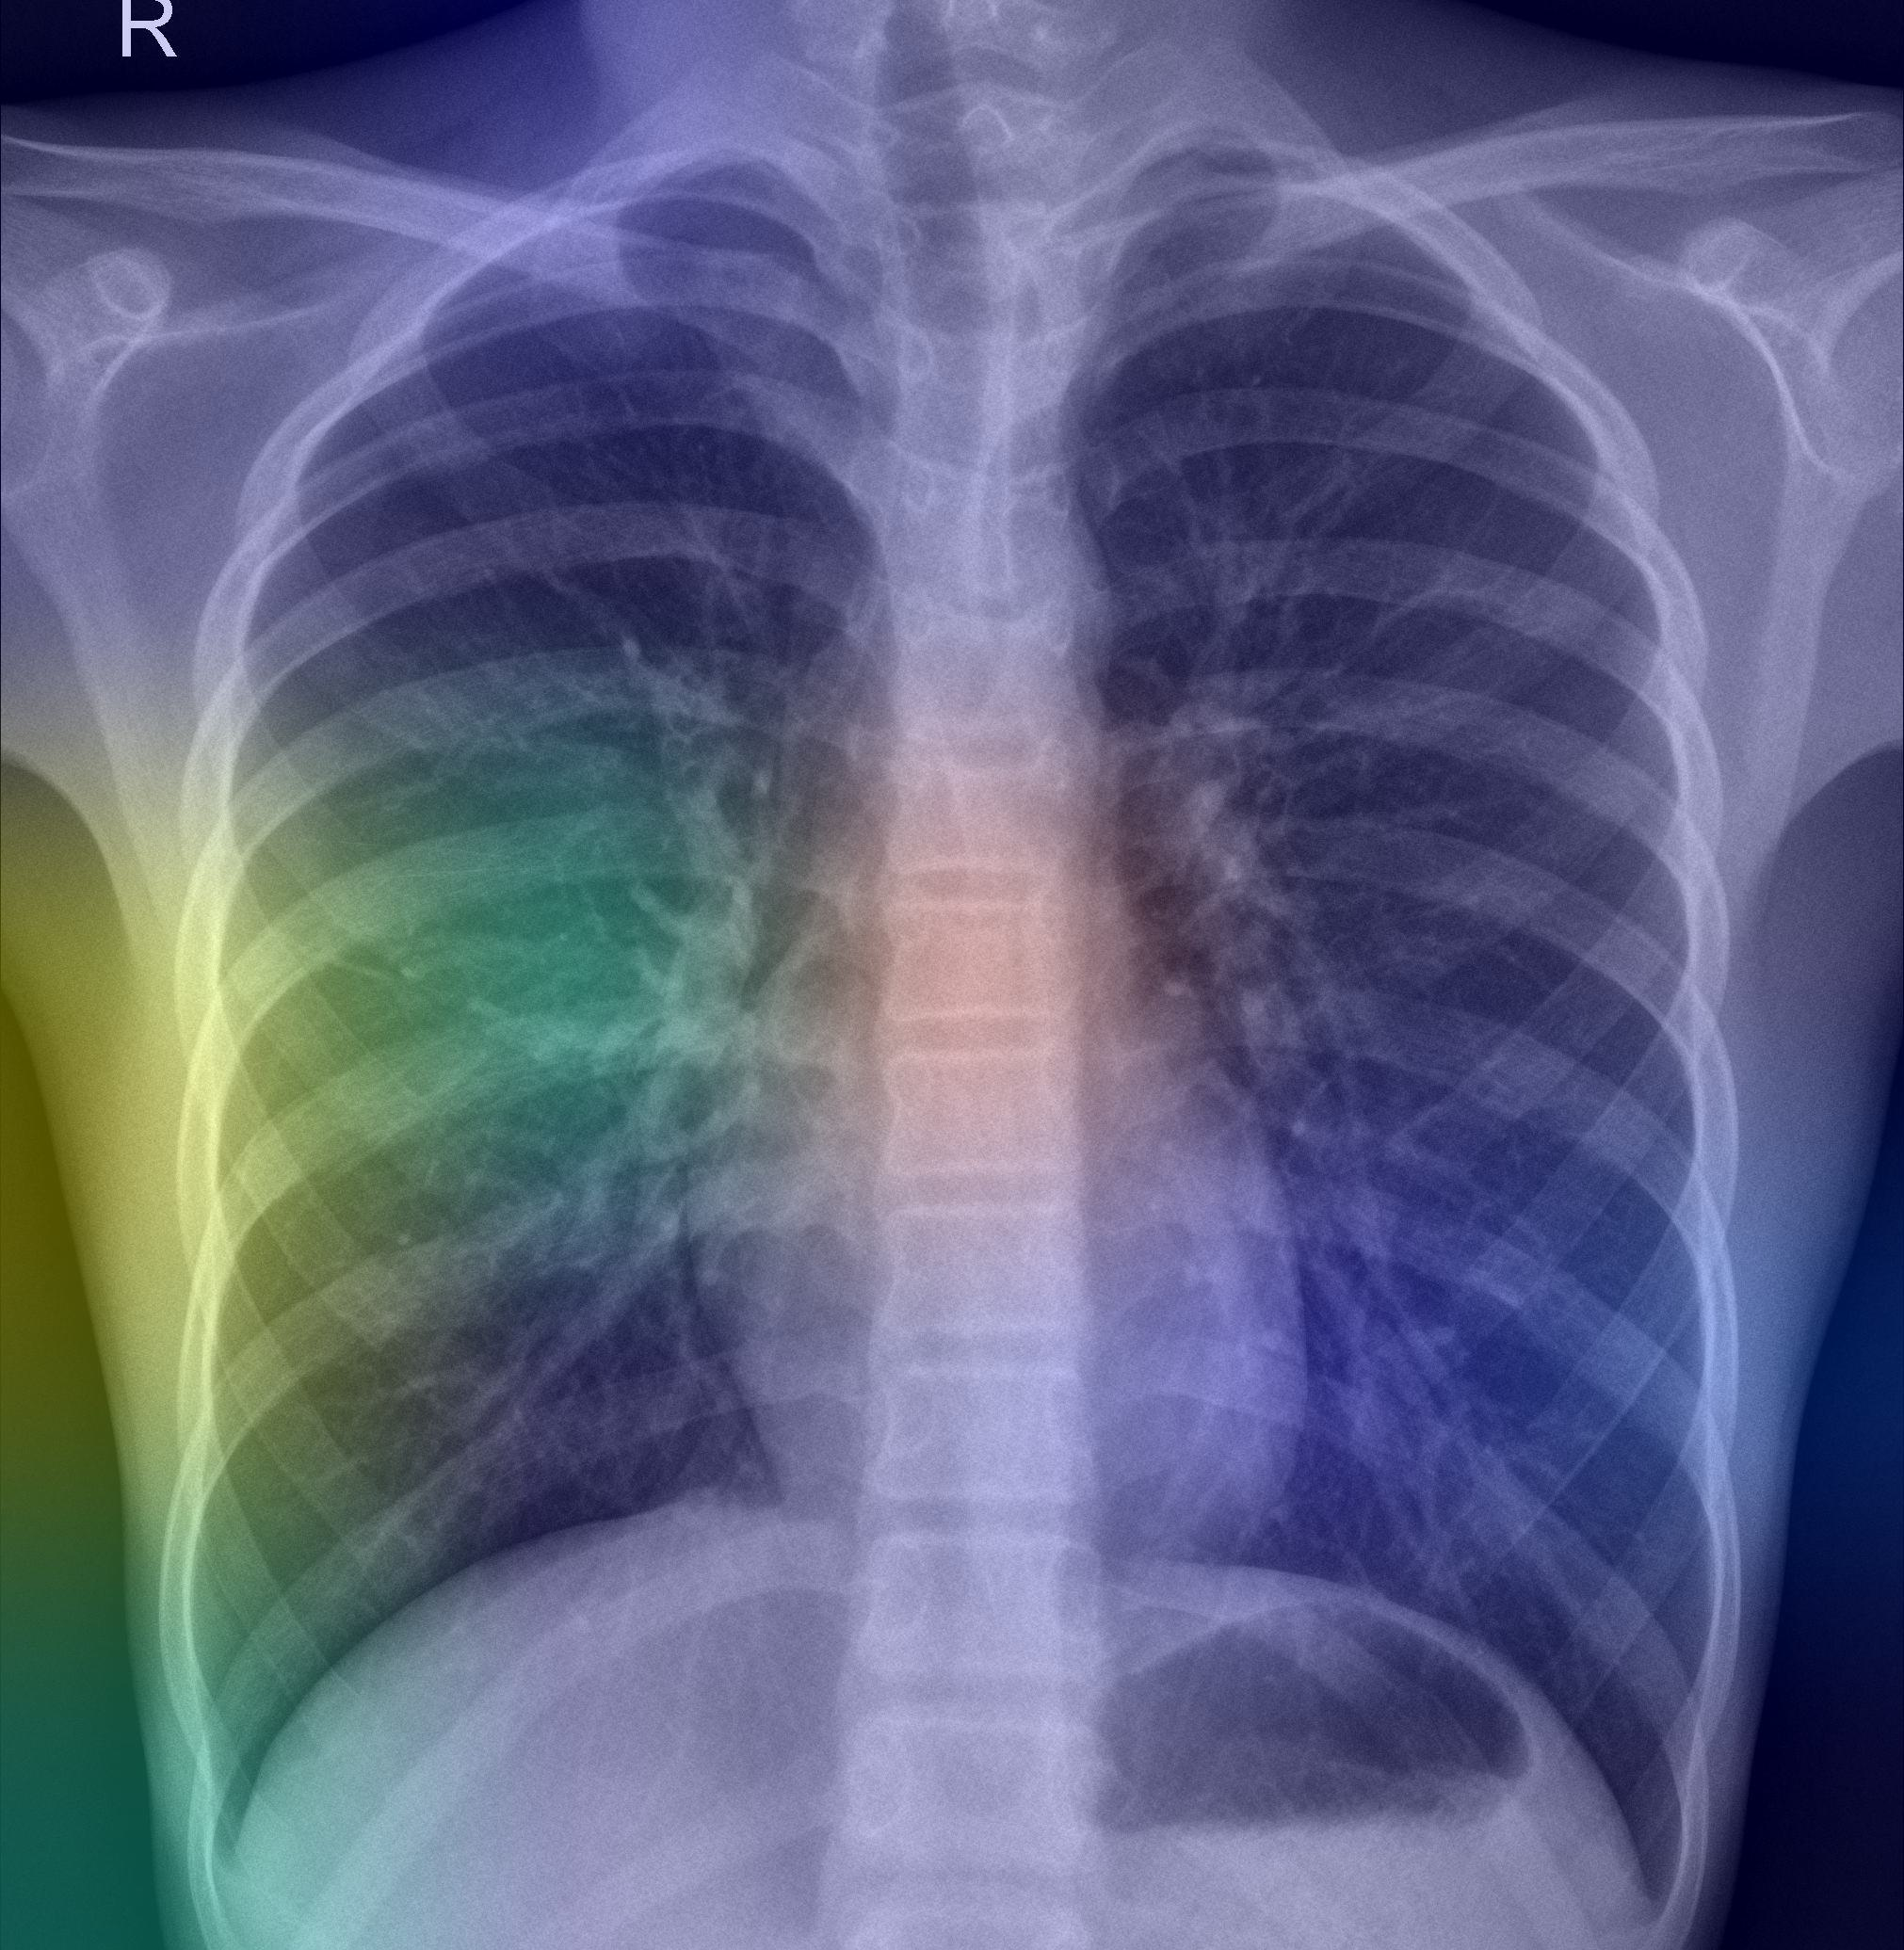


1/1 [==============================] - 0s 66ms/step
../data/data_sample/chest_xray/NORMAL/IM-0041-0001.jpeg
../output/gradcam/xray_model/NORMAL/IM-0041-0001.jpeg
[[5.4888005]]






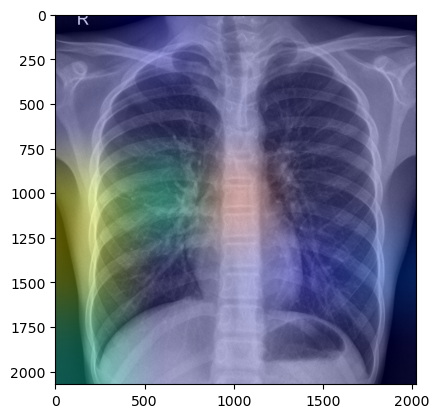

In [170]:
scan_label('N') # Normal

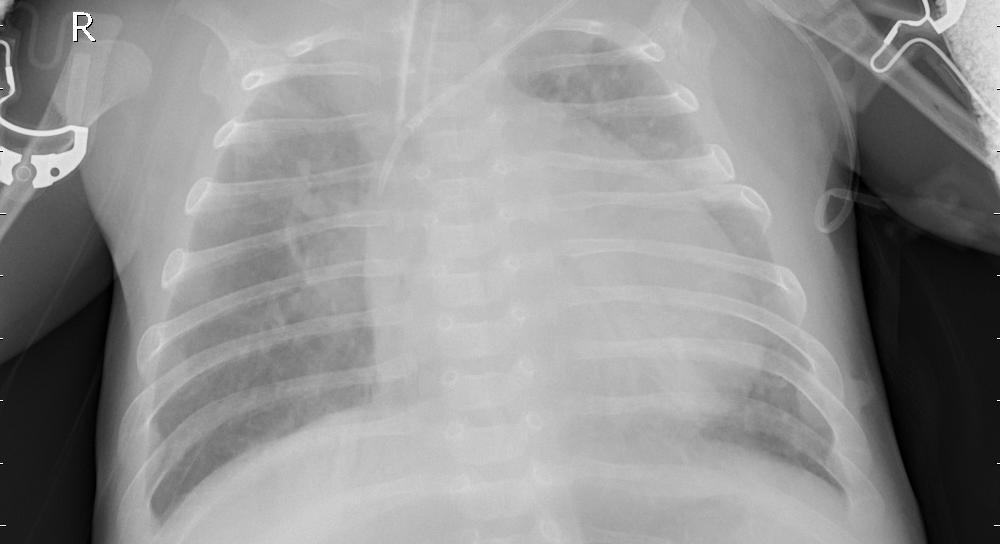

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_38216\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


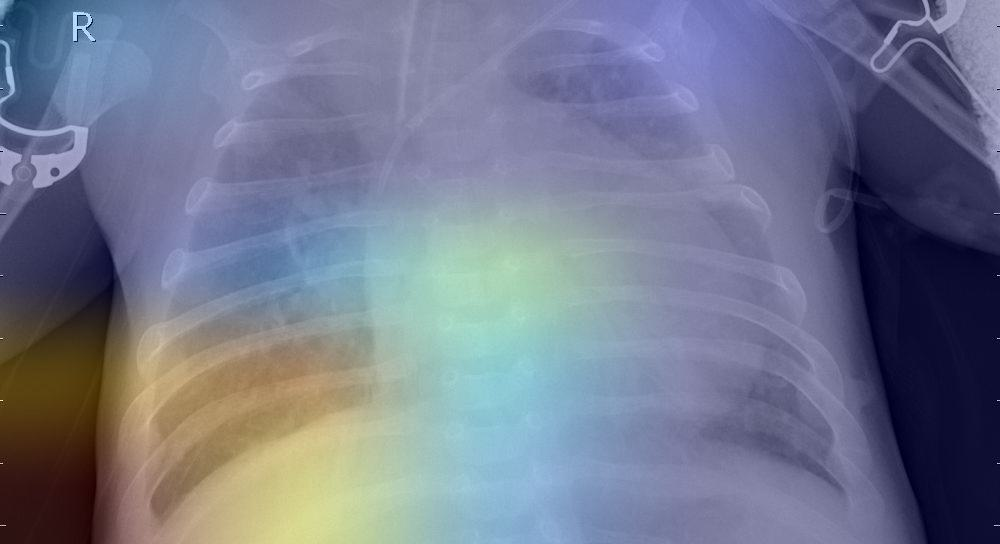


1/1 [==============================] - 0s 56ms/step
../data/data_sample/chest_xray/PNEUMONIA/person1_virus_7.jpeg
../output/gradcam/xray_model/PNEUMONIA/person1_virus_7.jpeg
[[11.308159]]






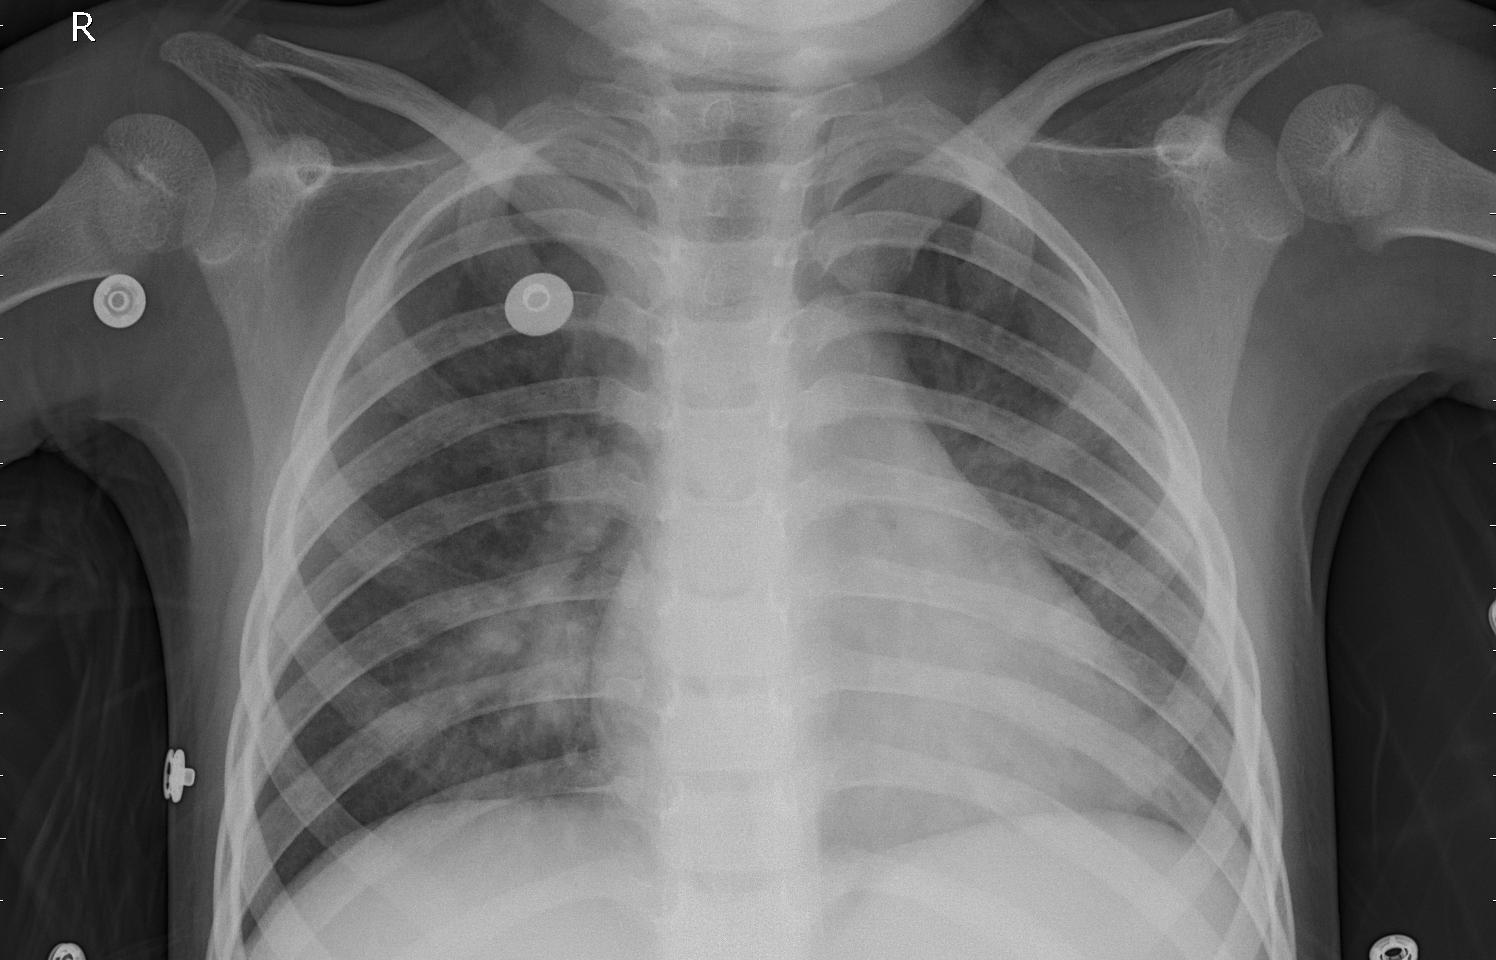

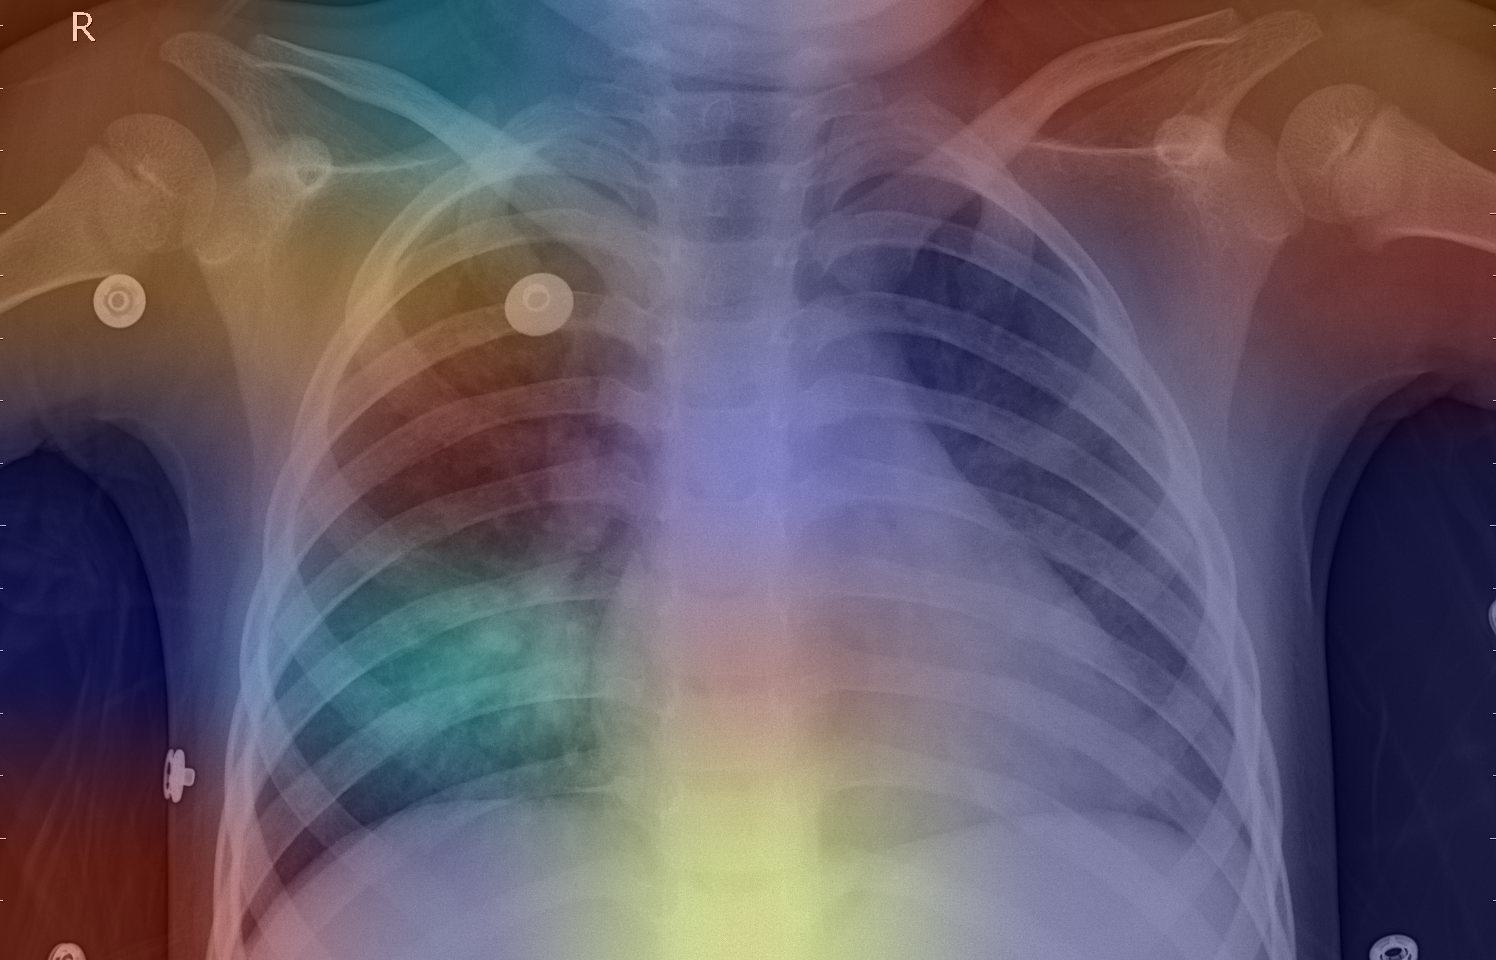


1/1 [==============================] - 0s 104ms/step
../data/data_sample/chest_xray/PNEUMONIA/person11_virus_38.jpeg
../output/gradcam/xray_model/PNEUMONIA/person11_virus_38.jpeg
[[12.103676]]






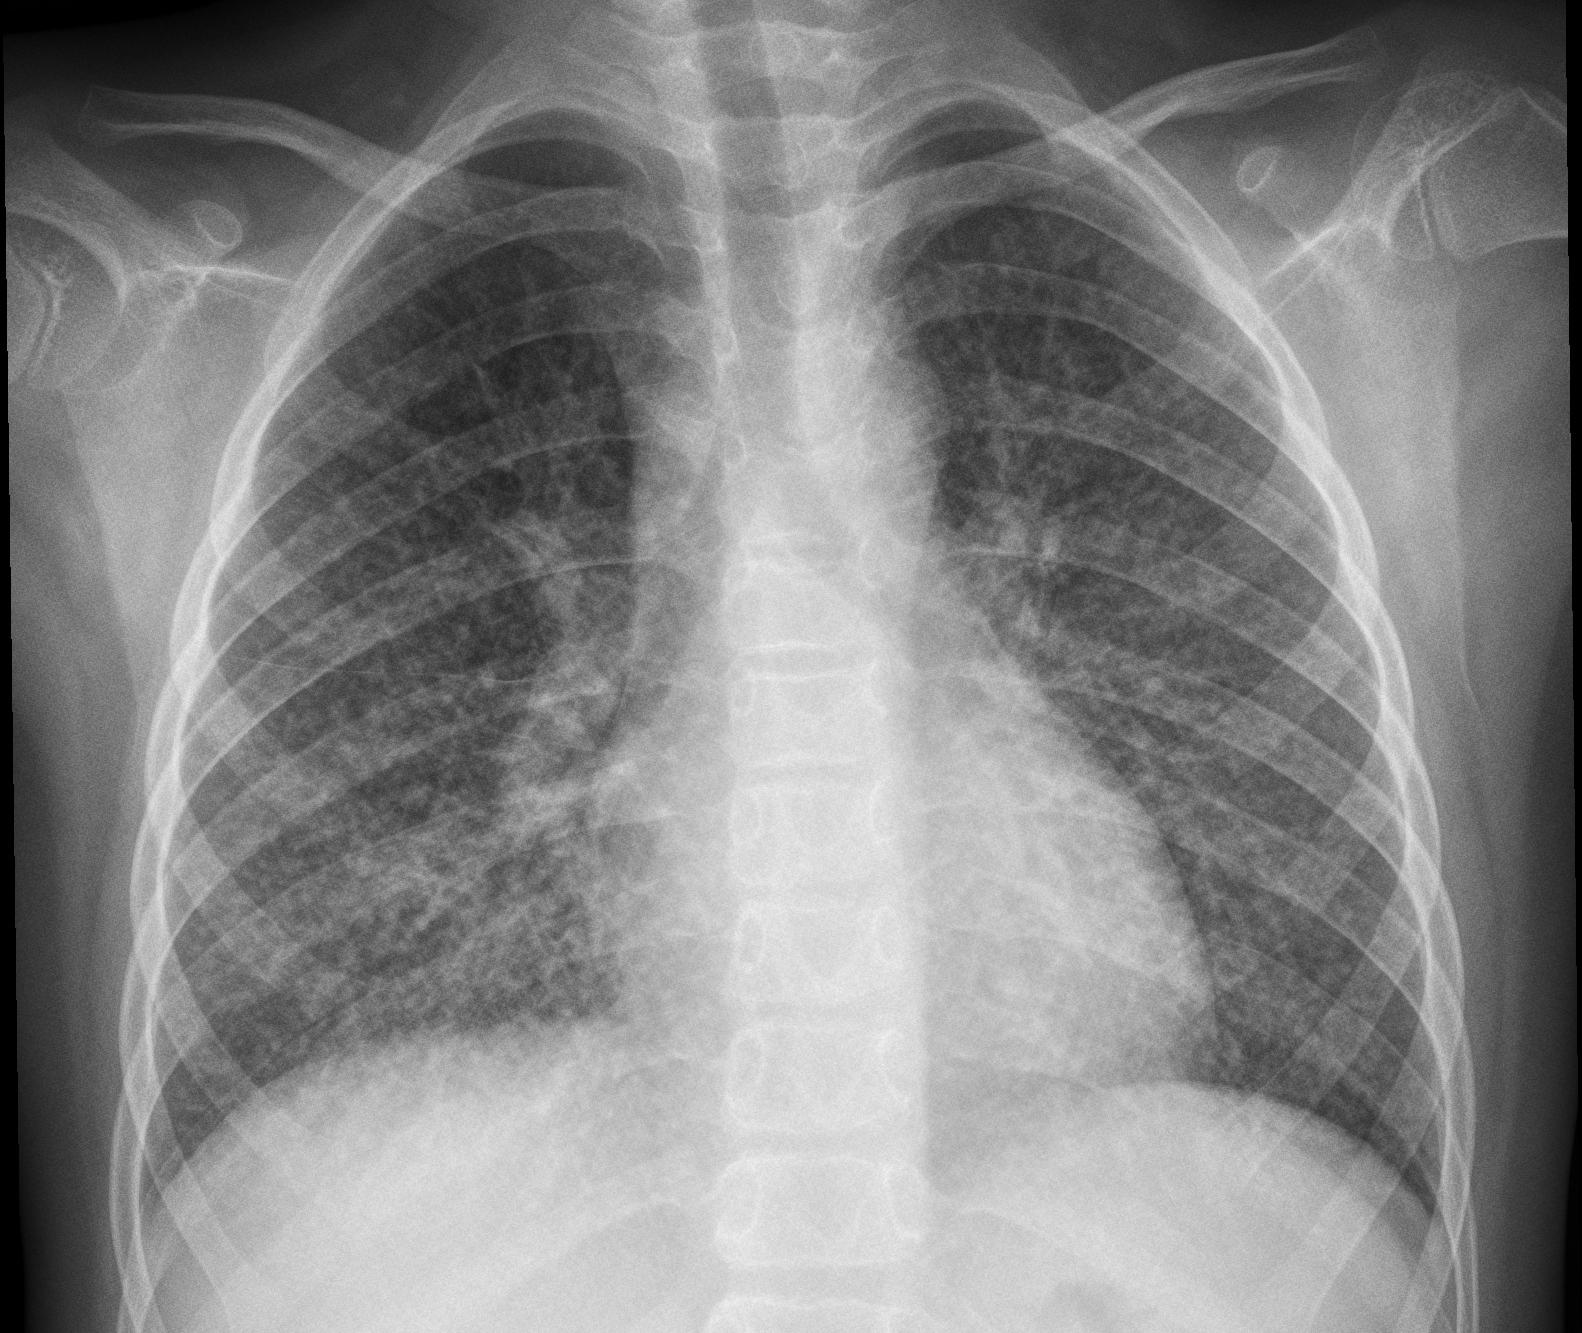

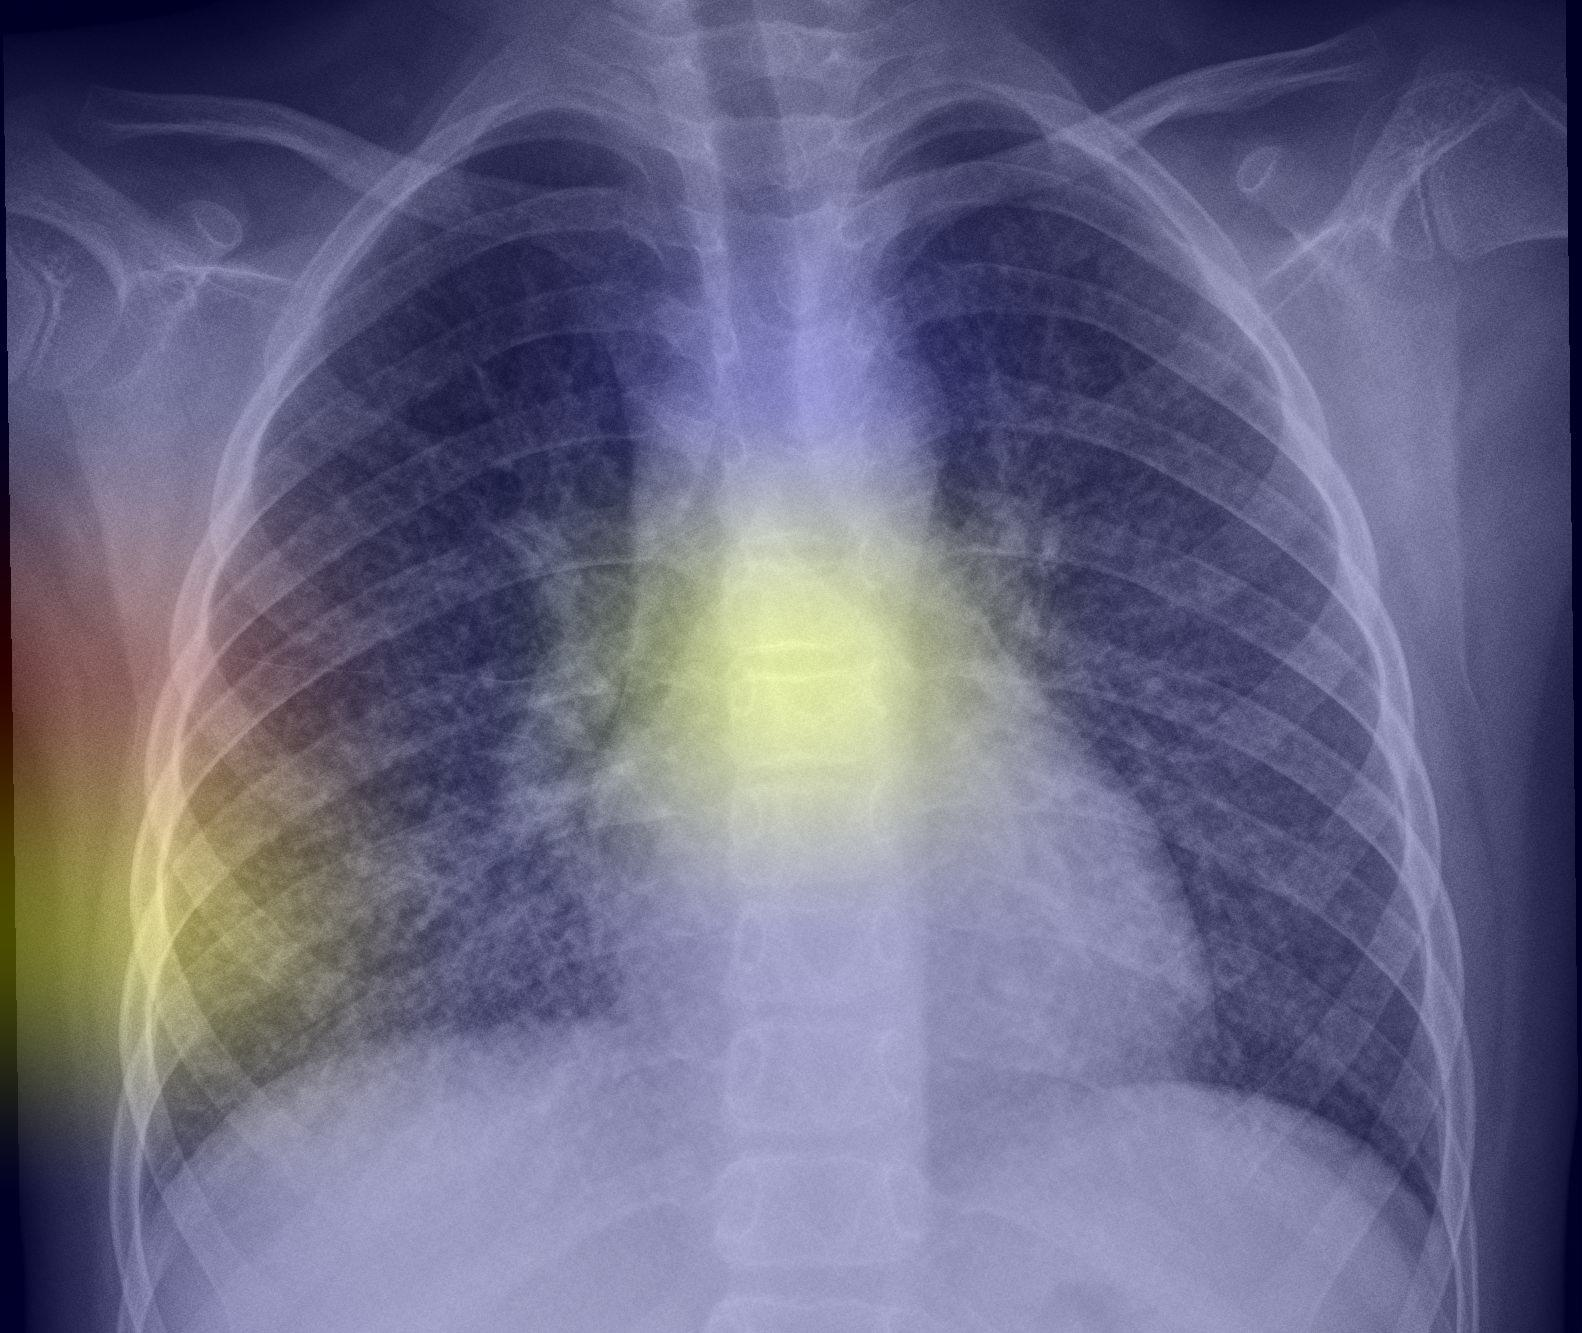


1/1 [==============================] - 0s 65ms/step
../data/data_sample/chest_xray/PNEUMONIA/person16_virus_47.jpeg
../output/gradcam/xray_model/PNEUMONIA/person16_virus_47.jpeg
[[4.118365]]






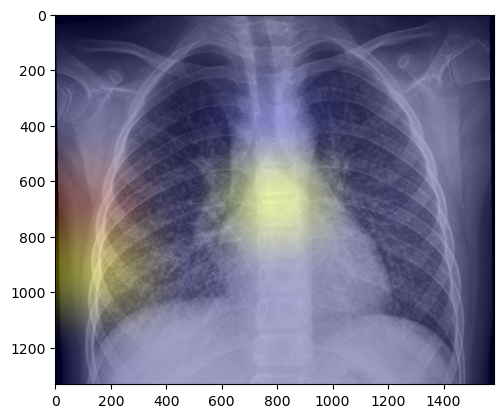

In [171]:
scan_label('P') # Pneumonia